# ft_sommelier

**Given only chemical attributes of a red wine, be able to classify that wine as a ‘good wine’ or a ‘bad wine’.**

- Fixed acidity
- Volatile acidity
- Citric acid
- Residual sugar
- Chlorides
- Free sulfur dioxide 
- Total sulfur dioxide 
- Density
- pH
- Sulphates
- Alcohol

## V.1 Exploring the green reds

As a beginner in machine learning, you recall that one of the best things to do before breaking out the machine learning tools is to explore and look at your data.

>Write a function that will plot a scatterplot matrix of your red wine data. Your function should plot wines with quality over some “good_threshold” as one color, and wines below some “bad_threshold” as another. Your plotting function should have the option to save a .png of your plots. Here’s an example function definition:

### a) plot_scatter_matrix 
Write a function that will plot a scatterplot matrix of your red wine data. Your function should plot wines with quality over some “good_threshold” as one color, and wines below some “bad_threshold” as another. Your plotting function should have the option to save a .png of your plots. Here’s an example function definition

In [264]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

wine_red_path = "./winequality-red.csv"
wine_white_path = "./winequality-white.csv"

red_data = pd.read_csv(wine_red_path, sep=';')
white_data = pd.read_csv(wine_white_path, sep=';')

In [340]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    data_len, category_len = wine_data.shape
    fig, axes = plt.subplots(category_len, category_len, figsize=(50,50))
    for i in range(category_len):
        for j in range(category_len):
            if (i == j):
                axes[i, j].text(0.5, 0.5, s=wine_data.columns[i], fontsize=30, horizontalalignment='center', verticalalignment='center')
            else:
                plot_x = wine_data.values[:, j]
                plot_y = wine_data.values[:, i]
                colors = ['g' if score >= good_threshold else 'r' if score <= bad_threshold else 'w' for score in wine_data['quality']]
                print_list = []
                for index, value in enumerate(colors):
                    if value != 'w':
                        print_list.append(index)
                print_x = []
                print_y = []
                print_c = []
                for index in range(len(print_list)):
                    print_x.append(plot_x[print_list[index]])
                    print_y.append(plot_y[print_list[index]])
                    print_c.append(colors[print_list[index]])
                axes[i, j].scatter(print_x, print_y, color=print_c)
    if (save_plot == True):
        plt.savefig('wine_result.png')
    else:
        plt.show()

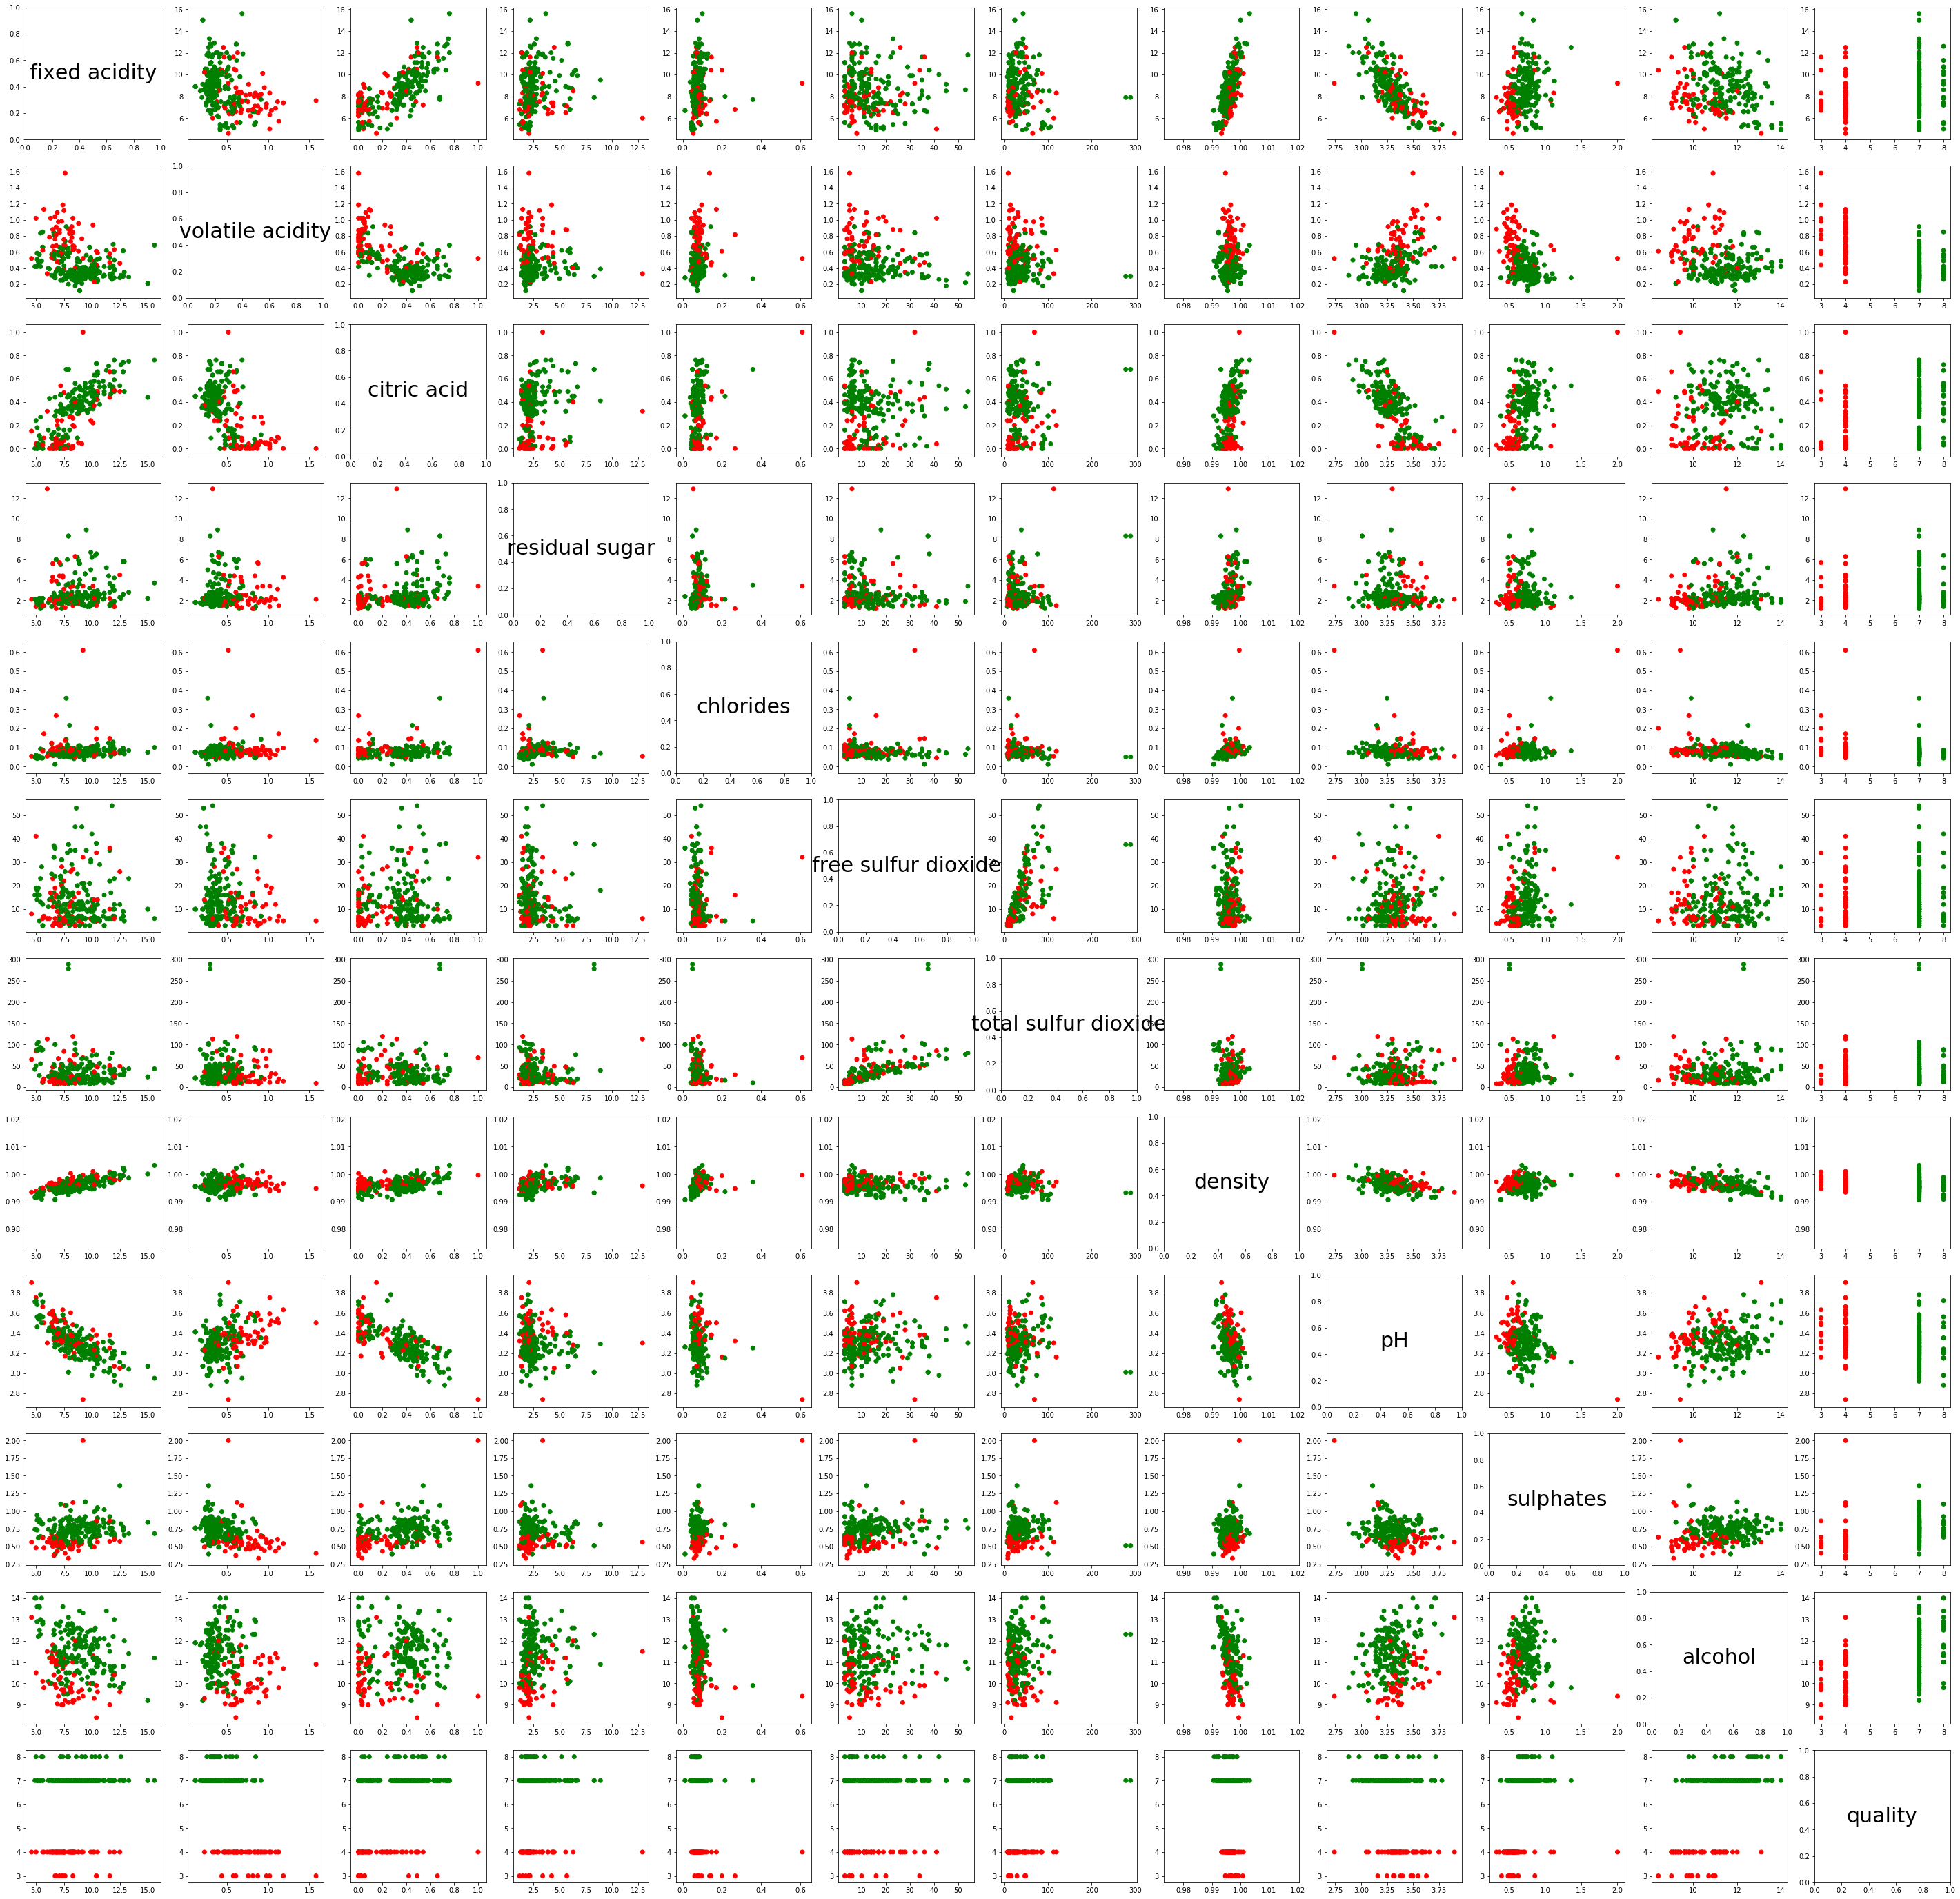

In [47]:
plot_scatter_matrix(red_data, 7, 4, True)

### b) which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines?
Alcohol and volatile acidity seems to be the most useful information according to this graph. Because the good and bad data are seperated enough to distinguish which is good or not. Next good one sees to be Alcohol and pH. Most of the data are mixed together in other metrics so other metrics seems hard to say its good.

## V.2 Learning to perceptron


Now that you’ve explored the red wines, it’s time to put together a perceptron that can learn to classify the wines as “good” or “bad” based on only chemical attributes!

### a) Implement a perceptron that:
- Has randomly initialized weights and bias
- Uses the Rosenblatt perceptron learning rule (with changeable learning rate) 
- Utilizes the heaviside step activation function (discrete version)

### b) You’ll need to implement a function to train your perceptron.
- Have a way to specify number of training epochs
- Train your perceptron until it makes no errors, if training epochs is set to 0, • Have a way to specify learning rate.
- Return a list of python tuples containing (performance):
> [(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias), . . . ]

In [2]:
import random

# Delete every data that doesn't fit in good or bad
def preprocess_data(x, y, good_threshold=7, bad_threshold=4):
    data = ["good" if score >= good_threshold else "bad" if score <= bad_threshold else "del" for score in y]
    remain_list = []
    for index, value in enumerate(data):
        if value != "del":
            remain_list.append(index)
    data_x = []
    data_y = []
    for index in range(len(remain_list)):
        data_x.append(x[remain_list[index]])
        data_y.append(y[remain_list[index]])
    return (data_x, data_y)

def one_hot_encoding(y, good_threshold=7, bad_threshold=4):
    return [1 if score >= good_threshold else 0 if score <= bad_threshold else "nan" for score in y]

In [700]:
# Initialize the input
good_threshold = 8
bad_threshold = 3
x = red_data[["pH", "alcohol"]].values
y = red_data[["quality"]].values
x, y = preprocess_data(x, y, good_threshold, bad_threshold)
y = one_hot_encoding(y, good_threshold, bad_threshold)
input_size = len(x[0])

In [14]:
def dot(x, y):
    total = 0
    for i in range(len(x)):
        total += x[i] * y[i]
    return total

In [384]:
class perceptron(object):
    def __init__(self, input_size, epoch=10, lr=0.01, threshold=0, verbose=False, seed=100):
        random.seed(seed)
        self.input_size = input_size
        self.epoch = epoch
        self.lr = lr
        self.threshold = threshold
        self.w = [random.random() for _ in range(input_size)]
        self.b = random.random()
        self.performance = []
        self.epoch_error = 0
        self.correct = 0
        self.total = 0
        self.verbose = verbose
        
    def h_activation(self, x):
        if (x >= self.threshold):
            return (1)
        else:
            return (0)

    def train(self, x, y):
        epoch = 1
        self.performance = []
        while(1):
            self.epoch_error = 0
            self.correct = 0
            self.total = 0
            for i, (x_, y_) in enumerate(zip(x, y)):
                result = self.h_activation(dot(x_, self.w) + self.b)
                error = y_ - result
                self.back_prop(x_, error)
                self.accuracy(result, y_)
                self.epoch_error += int(error != 0)
            if (self.verbose):
                print("Epoch {0}, accuracy : {1} error {2}".format(epoch, self.correct / self.total, self.epoch_error))
            self.record(epoch)
            if (epoch == self.epoch):
                break
            elif (self.epoch == 0 and self.epoch_error == 0):
                break
            epoch += 1
            
    def back_prop(self, x, error):
        for i in range(self.input_size):
            self.w[i] += self.lr * error * x[i]
        self.b += self.lr * error
    
    def accuracy(self, x, y):
        self.total += 1
        if (x == y):
            self.correct += 1
    
    def record(self, epoch):
        result = (epoch, self.epoch_error, self.w[:], self.b)
        self.performance.append(result)

In [59]:
# Initialize the input
good_threshold = 8
bad_threshold = 3
x = red_data[["pH", "alcohol"]].values
y = red_data[["quality"]].values
x, y = preprocess_data(x, y, good_threshold, bad_threshold)
y = one_hot_encoding(y, good_threshold, bad_threshold)
input_size = len(x[0])

In [60]:
# Testing the perceptron
p = perceptron(input_size, lr=0.1, epoch=0, verbose=False)
p.train(x, y)

In [61]:
# Adding one hot encoding result to the pandas data table
y = red_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
red_data['score'] = pd.Series(y, index=red_data.index)

In [62]:
# Sort the data out 
good_wine = red_data.loc[red_data["score"] == 1, ["pH", "alcohol", "score"]]
bad_wine = red_data.loc[red_data["score"] == 0, ["pH", "alcohol", "score"]]

In [63]:
good_bad_wine = pd.concat([good_wine, bad_wine])
good_bad_wine

pH  alcohol score
267   3.35    12.80     1
278   3.23    12.60     1
390   3.56    12.90     1
440   2.88     9.80     1
455   3.22    13.40     1
481   3.15    11.70     1
495   3.15    11.00     1
498   3.15    11.00     1
588   3.72    14.00     1
828   3.46    12.70     1
1061  3.21    12.50     1
1090  2.98    11.80     1
1120  3.20    13.10     1
1202  3.35    11.70     1
1269  3.50    14.00     1
1403  3.23    10.00     1
1449  3.23    11.30     1
1549  3.24    11.40     1
459   3.25     9.00     0
517   3.16     8.40     0
690   3.63    10.70     0
832   3.38     9.90     0
899   3.48    11.00     0
1299  3.50    10.90     0
1374  3.32     9.80     0
1469  3.31     9.70     0
1478  3.40    10.20     0
1505  3.55     9.95     0

### c) generate two plots in one figure
- The first plot should plot the number of errors your perceptron made as a function of epoch. Be careful with how you calculate errors!
- The second plot should plot the decision boundary of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!
- Your function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.

In [3]:
def linspace(min_n, max_n, dot_n):
    dot_list = []
    interval = (max_n - min_n) / dot_n
    for i in range(dot_n):
        dot_list.append(min_n + interval * i)
    dot_list.append(min_n + interval * dot_n)
    return (dot_list)

In [4]:
def max_min(data):
    max_value = float("-inf")
    min_value = float("inf")
    for i in range(len(data)):
        if (data[i] > max_value):
            max_value = data[i]
        if (data[i] < min_value):
            min_value = data[i]
    return max_value, min_value

# Check is the decision line is inside the fixed size of figure
# If the answer is no then change the size of figure
def check_decision_line(x, y, x_max, x_min, y_max, y_min):
    for x_, y_ in zip(x, y):
        if (x_min <= x_ <= x_max and y_min <= y_ <= y_max):
            return (1)
    return (0)

In [114]:
def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce a two plot figure:
    1) Classfication Errors vs. Epochs
    2) Decision boundary for two factors
    """
    # data preprocessing
    # Adding one hot encoding result to the pandas data table
    x_max, x_min = max_min(wine_data.values[:,1])
    y_max, y_min = max_min(wine_data.values[:,0])
    
    good_wine = wine_data.loc[wine_data["score"] == 1, ["pH", "alcohol", "score"]]
    bad_wine = wine_data.loc[wine_data["score"] == 0, ["pH", "alcohol", "score"]]
    
    # The values of the figure
    x_max += 0.25
    x_min -= 0.25
    y_max += 0.05
    y_min -= 0.05
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    # ax1
    ax1.set_title("Errors as a function of epoch")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("classification errors")
    
    # draw a line
    draw_epoch = pd.DataFrame(performance).iloc[0:epoch,0].values
    draw_error = pd.DataFrame(performance).iloc[0:epoch,1].values
    ax1.plot(draw_epoch, draw_error, 'b')
    
    # ax2
    ax2.set_title("Decision boundary on epoch: {0}".format(epoch if epoch != -1 else len(performance)))
    ax2.set_xlabel("alcohol")
    ax2.set_ylabel("pH")
    
    # draw a line
    # w1 -> pH (y)
    # w2 -> alcohol (x)
    # y * w1 + x * w2 + b = 0
    # y = -(w2/w1)x - b/w1
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    b = performance[epoch][3]
    plot_x = linspace(x_min, x_max, 100)
    plot_y = [(-1 * (w2 / w1) * x) - (b / w1) for x in plot_x]
    ax2.plot(plot_x, plot_y, '--b', label="Decision Boundary")
    ax2.scatter(bad_wine.iloc[:,1].values, bad_wine.iloc[:,0].values, color='r', label="bad wines (<{0} score)".format(bad_thresh +1))
    ax2.scatter(good_wine.iloc[:,1].values, good_wine.iloc[:,0].values, color='g', label="good wines (>{0} score)".format(good_thresh -1))
    
    # Check is the decision line is inside the figure
    # And if the decision line is out of the figure modify the figure size
    if (check_decision_line(plot_x, plot_y, x_max, x_min, y_max, y_min) == 0):
        decision_y_max, decision_y_min = max_min(plot_y)
        if (decision_y_min >= y_max):
            y_max = decision_y_max
        elif (decision_y_max <= y_min):
            y_min = decision_y_min
            
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    
    # legend
    ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Fill the color
    diff_y = y_max - y_min + 10
    plot_y_up_line = [y + diff_y for y in plot_y]
    plot_y_down_line = [y - diff_y for y in plot_y]
    ax2.fill_between(plot_x, plot_y, plot_y_up_line, where=plot_y_up_line >= plot_y, facecolor='r', alpha=0.3)
    ax2.fill_between(plot_x, plot_y, plot_y_down_line, where=plot_y_down_line < plot_y, facecolor='g', alpha=0.3)
    
    # Save the results
    if (save_plot == True):
        plt.savefig("train_result_epoch{0}.png".format(epoch))
    else:
        plt.show()

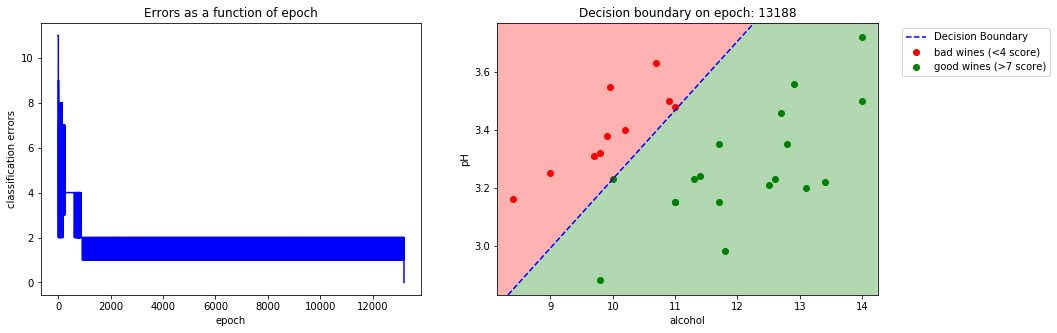

In [67]:
plot_performance(p.performance, good_bad_wine, good_threshold, bad_threshold, save_plot=False)

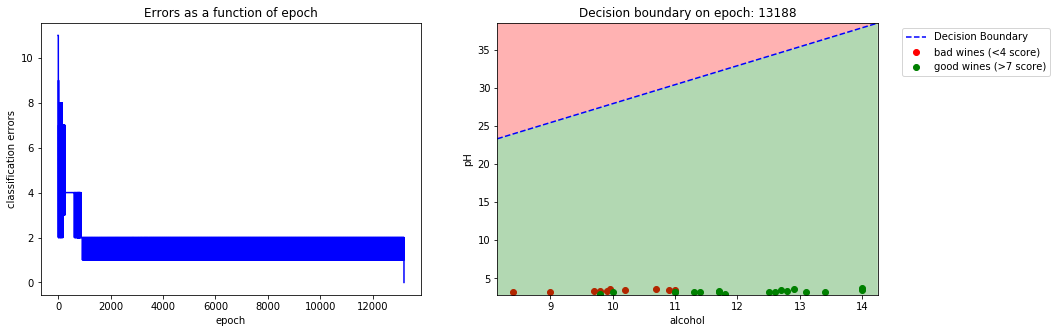

In [68]:
plot_performance(p.performance, good_bad_wine, good_threshold, bad_threshold, epoch=0)

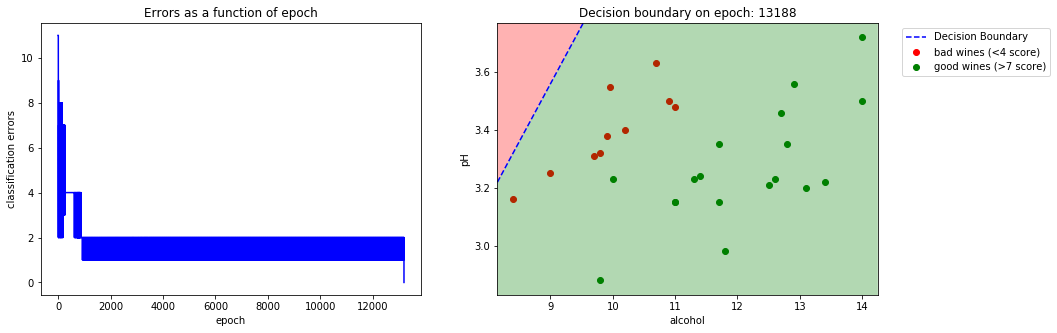

In [69]:
plot_performance(p.performance, good_bad_wine, good_threshold, bad_threshold, epoch=10)

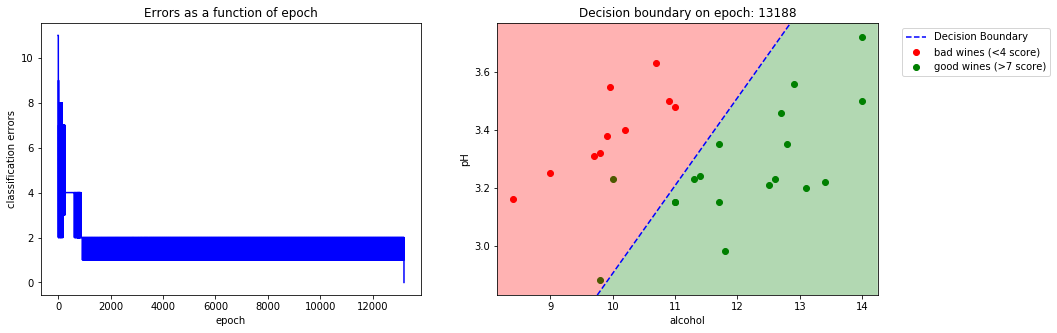

In [70]:
plot_performance(p.performance, good_bad_wine, good_threshold, bad_threshold, epoch=50)

### d) Feature Scaling
Your perceptron appears to work...but why is it taking so many epochs to train? Maybe you can modify the red wine data to help the perceptron learn more quickly? Use the function you just created in part c) to plot and verify that your perceptron is learning more efficiently!

In [71]:
# Initialize the input
good_threshold = 8
bad_threshold = 3

# Adding one hot encoding result to the pandas data table
y = red_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
red_data['score'] = pd.Series(y, index=red_data.index)

# Sort the data out 
good_wine = red_data.loc[red_data["score"] == 1, ["pH", "alcohol", "score"]]
bad_wine = red_data.loc[red_data["score"] == 0, ["pH", "alcohol", "score"]]
good_bad_wine = pd.concat([good_wine, bad_wine])

In [9]:
# Change the data to between 0 and 1
def feature_scaling(data_list):
    data_max, data_min = max_min(data_list)
    if (data_max == data_min):
        return (data_list)
    diff_data = data_max - data_min
    scaled_list = [(data - data_min) / diff_data for data in data_list]
    return (scaled_list)

good_bad_wine["pH"] = feature_scaling(good_bad_wine.values[:,0])
good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,1])

In [73]:
good_bad_wine

pH   alcohol score
267   0.559524  0.785714     1
278   0.416667  0.750000     1
390   0.809524  0.803571     1
440   0.000000  0.250000     1
455   0.404762  0.892857     1
481   0.321429  0.589286     1
495   0.321429  0.464286     1
498   0.321429  0.464286     1
588   1.000000  1.000000     1
828   0.690476  0.767857     1
1061  0.392857  0.732143     1
1090  0.119048  0.607143     1
1120  0.380952  0.839286     1
1202  0.559524  0.589286     1
1269  0.738095  1.000000     1
1403  0.416667  0.285714     1
1449  0.416667  0.517857     1
1549  0.428571  0.535714     1
459   0.440476  0.107143     0
517   0.333333  0.000000     0
690   0.892857  0.410714     0
832   0.595238  0.267857     0
899   0.714286  0.464286     0
1299  0.738095  0.446429     0
1374  0.523810  0.250000     0
1469  0.511905  0.232143     0
1478  0.619048  0.321429     0
1505  0.797619  0.276786     0

In [75]:
x = good_bad_wine[["pH", "alcohol"]].values
y = good_bad_wine["score"].values
# Testing the perceptron with scaled 
p = perceptron(input_size=2, lr=0.1, epoch=0, verbose=True)
p.train(x, y)

Epoch 1, accuracy : 0.75 error 7
Epoch 2, accuracy : 1.0 error 0


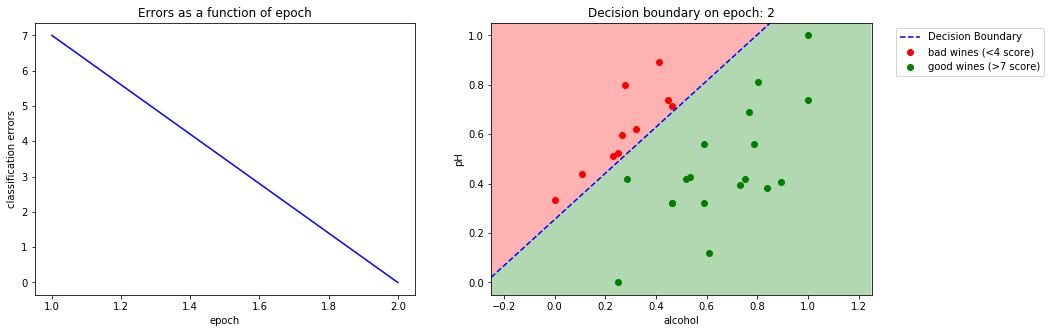

In [77]:
plot_performance(p.performance, good_bad_wine, good_threshold, bad_threshold, save_plot=False)

**Compared to the feature unscaled training this is way much faster and efficient! When we give input with a specific range the perceptron it will train there weight and bias with no bias by specific big input.**

## V.3 My fair ADALINE


Encouraged by the results of your perceptron, you decide to see if you can use it to
distinguish between wines with a score of 4 and lower, and wines with a score of 7 and higher. Feeling confident, you decide to let the perceptron train until it can find the best decision boundary.

In [78]:
# Initialize the input
good_threshold = 7
bad_threshold = 4

# Adding one hot encoding result to the pandas data table
y = red_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
red_data['score'] = pd.Series(y, index=red_data.index)

# Sort the data out 
good_wine = red_data.loc[red_data["score"] == 1, ["pH", "alcohol", "score"]]
bad_wine = red_data.loc[red_data["score"] == 0, ["pH", "alcohol", "score"]]
good_bad_wine = pd.concat([good_wine, bad_wine])
good_bad_wine["pH"] = feature_scaling(good_bad_wine.values[:,0])
good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,1])

In [122]:
x = good_bad_wine[["pH", "alcohol"]].values
y = good_bad_wine["score"].values
# Testing the perceptron with scaled 
p = perceptron(input_size=2, lr=0.001, epoch=20000, verbose=False)
p.train(x, y)

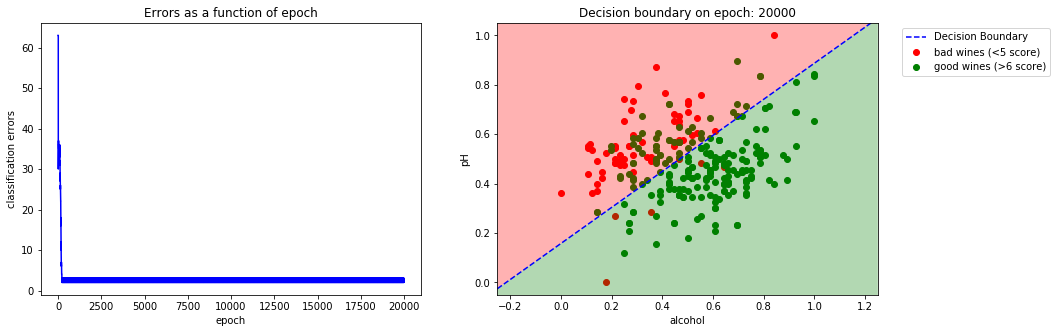

In [123]:
plot_performance(p.performance, good_bad_wine, good_threshold, bad_threshold, epoch=100, save_plot=False)

### a) Marvin notices and chides you for torturing your perceptron. Why?
You decide to upgrade your perceptron to handle this harder classification task. You’ve heard a bit about the gradient descent technique and also about ADALINE, maybe these will do the trick?

`The problem is that it will never end because there will be always an error. This will never end because this perceptron only stops when there is an no error. If you give learning rate high it will show you that the boundary line is totally gone off the cluster. Because it measures the error one by one and the data ends in bad data the line will move dramatically to satisfy the bad data. when it see teh good data it will move way higher to satisfy good data. So there is 3 solutions here.`
1. Make the data mixed up with good and bads
2. Apply batch learning
3. lower the learning rate so it won't get off to far in once

### b) Implement an ADALINE that:
- Has randomly initialized weights and bias
- Uses a linear activation function and some kind of quantizer
- Uses the Widrow-Hoff learning rule

### c) You’ll need to implement a function to train your ADALINE. Your training function should:
**Gradient descent, know it, love it!**
- Take in your red wine data as a parameter
- Have a way to specify number of training epochs
- If training epochs is set to 0, your ADALINE should train until it converges on a good set of weights.
- Have a way to specify learning rate.
- Have an option to perform either online learning or batch learning

In [6]:
import math

def heaviside_activation(x, threshold):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if (x[i][j] >= threshold):
                x[i][j] = 1
            else:
                x[i][j] = 0
    return x

def dot(x, y):
    total = 0
    for i in range(len(x)):
        total += x[i] * y[i]
    return total

def transpose_matrix_2d(matrix):
    row = len(matrix)
    col = len(matrix[0])
    t_matrix = [[0 for _ in range(row)] for _ in range(col)]
    for i in range(col):
        for j in range(row):
            t_matrix[i][j] = matrix[j][i]
    return t_matrix

def mul_matrix(x, y):
    if (len(x[0]) != len(y)):
        raise Exception("Invalid matrix multiplication matrix ({0},{1}) and matrix ({2},{3}) size must match".format(len(x), len(x[0]), len(y), len(y[0])))
    y = transpose_matrix_2d(y)
    row = len(x)
    col = len(y)
    result = [[0 for _ in range(col)] for _ in range(row)]
    for i in range(len(x)):
        for j in range(len(y)):
            result[i][j] = dot(x[i], y[j])
    return result

In [7]:
def get_batch(x, y, batch_size):
    iter_n = len(y) // batch_size
    if (len(y) % batch_size != 0):
        iter_n += 1
    # if x is 1d array make it to 2d
    if (x[0].shape == ()):
        x = [list(x)]
    y = list(y)
    for i in range(iter_n):
        if (i == (iter_n - 1)):
            batch_x = x[batch_size*i:]
            batch_y = y[batch_size*i:]
        else:
            batch_x = x[batch_size*i:batch_size*(i+1)]
            batch_y = y[batch_size*i:batch_size*(i+1)]
        yield batch_x, batch_y

In [19]:
class nn_adaline(object):
    def __init__(self, input_size, batch_size=1, output_size=1, epoch=10, lr=0.1, threshold=0.5, verbose=False, seed=100):
        random.seed(seed)
        self.input_size = input_size
        self.output_size = output_size
        self.epoch = epoch
        self.batch_size = batch_size
        self.lr = lr
        self.threshold = threshold
        self.w = [[random.random() for _ in range(output_size)] for _ in range(input_size)]
        self.b = random.random()
        self.performance = []
        self.correct = 0
        self.total = 0
        self.verbose = verbose
        self.total_batch = 0

    def train(self, x, y):
        epoch = 1
        self.total_batch = len(y) // self.batch_size
        if (len(y) % self.batch_size != 0):
            self.total_batch += 1
        while(1):
            self.epoch_error = 0
            self.correct = 0
            self.total = 0
            batch = iter(get_batch(x, y, self.batch_size))
            cost = 0
            for batch_i, (batch_x, batch_y) in enumerate(batch):
                result = mul_matrix(batch_x, self.w)
                result = self.add_bias(result, self.b)
                result = self.activation(result)
                # This calculates the error before the quantizer(heaviside activation)
                # This is the main difference of perceptron that we can apply gradiant descent
                # But the MSE error will be still same as perceptron after we different
                
                # When you switch this and set the batch to 1 then it is exactly same as perceptron
                error = self.mse(result, batch_y)
                result = heaviside_activation(result, self.threshold)

                cost += (error ** 2) / 2
                self.accuracy(result, batch_y)
                self.back_prop(batch_x, error)
                if (self.verbose):
                    print("Epoch {0}, batch {1}/{2} accuracy : {3} cost {4}".format(epoch,
                                                                                     batch_i + 1,
                                                                                     self.total_batch,
                                                                                     self.correct / self.total,
                                                                                     cost))
                    
            self.record(epoch)
            if (epoch == self.epoch):
                break
            elif (self.epoch == 0 and cost <= 0.1):
                break
            epoch += 1
            
    def back_prop(self, x, error):
        current_batch_size = len(x)
        for batch in range(current_batch_size):
            for i in range(self.input_size):
                for j in range(self.output_size):
                    self.w[i][j] += self.lr * error * x[batch][i] * 2
        self.b += self.lr * error * 2
        
    def add_bias(self, x, b):
        for i in range(len(x)):
            for j in range(len(x[0])):
                x[i][j] += b
        return x
    
    # mse needs to be 
    def mse(self, x, y):
        error_total = 0
        error = 0
        if (self.output_size == 1):
            y = [[value] for value in y]
        for i, (x_, y_) in enumerate(zip(x, y)):
            for j in range(self.output_size):
                error += y_[j] - x_[j]
            error_total += error
        return (error_total / (i + 1))
    
    def activation(self, x):
        for i in range(len(x)):
            for j in range(len(x[0])):
                x[i][j] += (1 / (1 + math.exp(x[i][j])))
        return x
    
    def is_same(self, x, y):
        for i in range(self.output_size):
            if (x[i] != y[i]):
                return False
        return True
    
    def accuracy(self, x, y):
        if (self.output_size == 1):
            y = [[value] for value in y]
        for i, (x_, y_) in enumerate(zip(x, y)):
            if (self.is_same(x_, y_)):
                self.correct += 1
        self.total += (i + 1)
    
    def record(self, epoch):
        # change w in to 1d array when the outsize
        if (self.output_size == 1):
            w = [w_[0] for w_ in self.w[:]]
        else:
            w = self.w[:]
        result = (epoch, self.total - self.correct, w, self.b)
        self.performance.append(result)


### Batch size & output size & online learning available perceptron
- x = [batch_size * input_size]
- y = [batch_size * output_size]
- w = [input_size * output_Size]

In [36]:
# Testing the adaline
x = good_bad_wine[["pH", "alcohol"]].values
y = good_bad_wine["score"].values
nn = adaline(input_size = 2, batch_size=280, lr = 0.000001, epoch = 3000)
nn.train(x, y)

#### online learning
**`batch_size` = 1  `lr` = 0.001 `epoch` = 3086**

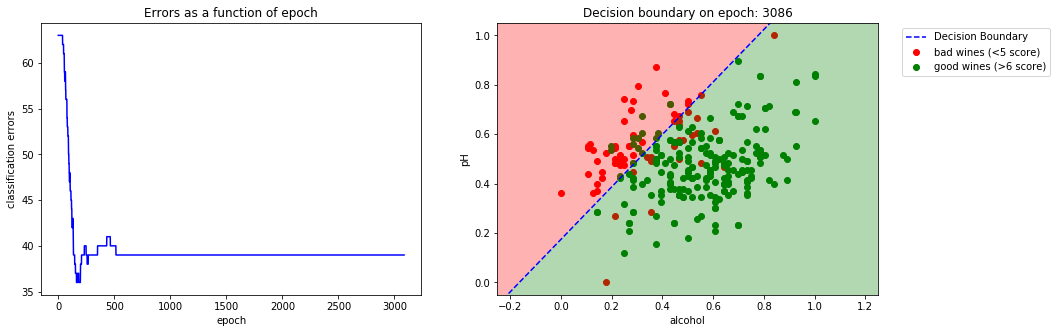

In [32]:
plot_performance(nn.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

**`batch_size` = 50  `lr` = 0.00001 `epoch` = 2993**

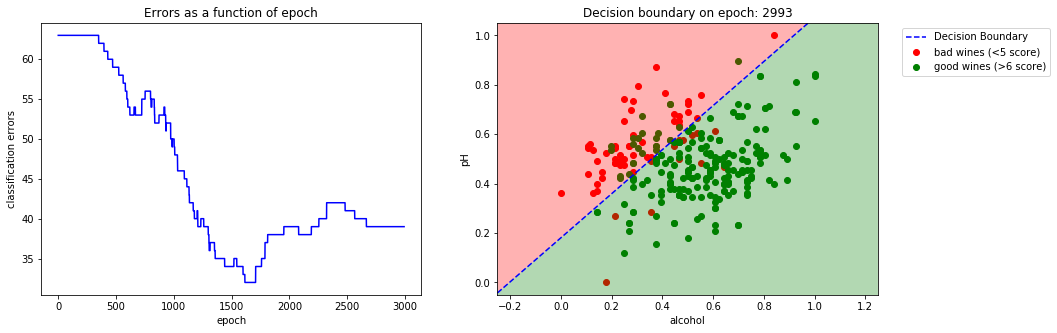

In [30]:
plot_performance(nn.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

**`batch_size` = 100  `lr` = 0.00001 `epoch` = 1000**

### Batch learning - what we are going to use

In [298]:
class adaline(object):
    def __init__(self, input_size, epoch=10, lr=0.01, threshold=0.5, verbose=False, seed=100):
        random.seed(seed)
        self.input_size = input_size
        self.epoch = epoch
        self.lr = lr
        self.threshold = threshold
        self.w = [random.random() for _ in range(input_size)]
        self.b = random.random()
        self.performance = []
        self.verbose = verbose
        self.epoch_error = 0
        
    def train(self, x, y):
            epoch = 1
            while (1):
                xy = list(zip(x, y))
                random.shuffle(xy)
                x = [x[0] for x in xy]
                y = [y[1] for y in xy]
                self.epoch_error = 0
                cost = 0
                result = self.net_input(x)

                # This calculates the error before the quantizer(heaviside activation)
                # This is the main difference of perceptron that we can apply gradiant descent
                # But the MSE error will be still same as perceptron after we different

                # When you switch this and set the batch to 1 then it is exactly same as perceptron
                error = [y[i] - result[i][0] for i in range(len(result))]
                weight = mul_matrix(transpose_matrix_2d(x), transpose_matrix_2d([error]))
                weight = transpose_matrix_2d(weight)[0]
                result = heaviside_activation(result, self.threshold)
                cost += sum([e**2 for e in error]) / 2
                self.back_prop(weight, error)
                self.classification_error(result, y)
                if (self.verbose):
                    print("Epoch {0}, error {1}, cost {2}".format(epoch, self.epoch_error, cost))
                self.record(epoch)
                if (epoch == self.epoch):
                    return (self.inference(x, y))
                elif (self.epoch == 0 and cost <= 0.5):
                    return (self.inference(x, y))
                    break
                epoch += 1
                
    def inference(self, x, y):
        self.epoch_error = 0
        result = self.net_input(x)
        result = heaviside_activation(result, self.threshold)
        self.classification_error(result, y)
        return ((len(x) - self.epoch_error) / len(x))
            
    def classification_error(self, x, y):
        for i in range(len(x)):
            if (x[i][0] != y[i]):
                self.epoch_error += 1
                
    def net_input(self, x):
        return (self.activation(self.add_bias(mul_matrix(x, transpose_matrix_2d([self.w])))))
                
    def add_bias(self, x):
        for i in range(len(x)):
            x[i][0] += self.b
        return x
            
    def back_prop(self, weight, error):
        for i in range(self.input_size):
            self.w[i] += self.lr * weight[i]
        self.b += self.lr * sum(error)
    
    def record(self, epoch):
        result = (epoch, self.epoch_error, self.w[:], self.b)
        self.performance.append(result)
        
    def activation(self, x):
        for i in range(len(x)):
            x[i][0] += 1 / (1 + math.exp(x[i][0]))
        return x
    
    def clear_data(self):
        self.performance = []
        self.w = [random.random() for _ in range(self.input_size)]
        self.b = random.random()

In [120]:
# Initialize the input
good_threshold = 8
bad_threshold = 3

# Adding one hot encoding result to the pandas data table
y = red_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
red_data['score'] = pd.Series(y, index=red_data.index)

# Sort the data out 
good_wine = red_data.loc[red_data["score"] == 1, ["pH", "alcohol", "score"]]
bad_wine = red_data.loc[red_data["score"] == 0, ["pH", "alcohol", "score"]]
good_bad_wine = pd.concat([good_wine, bad_wine])
good_bad_wine["pH"] = feature_scaling(good_bad_wine.values[:,0])
good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,1])

In [169]:
# Testing the adaline
x = good_bad_wine[["pH", "alcohol"]].values
y = good_bad_wine["score"].values
a = adaline(input_size = 2, lr = 0.001, epoch = 700)
a.train(x, y)

### batch learning
**`lr` = 0.001 `epoch` = 14899**

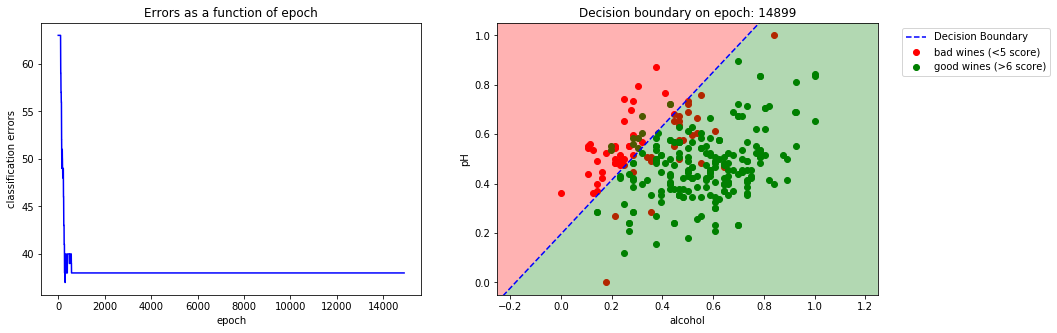

In [52]:
plot_performance(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

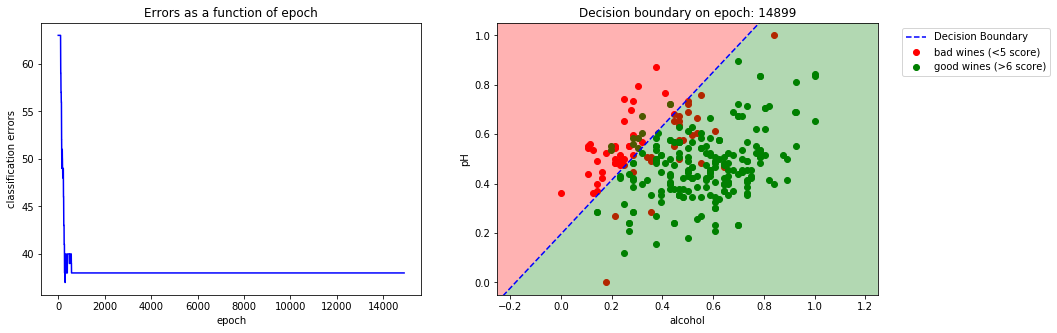

In [52]:
plot_performance(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

**`lr` = 0.0001 `epoch` = 14711**

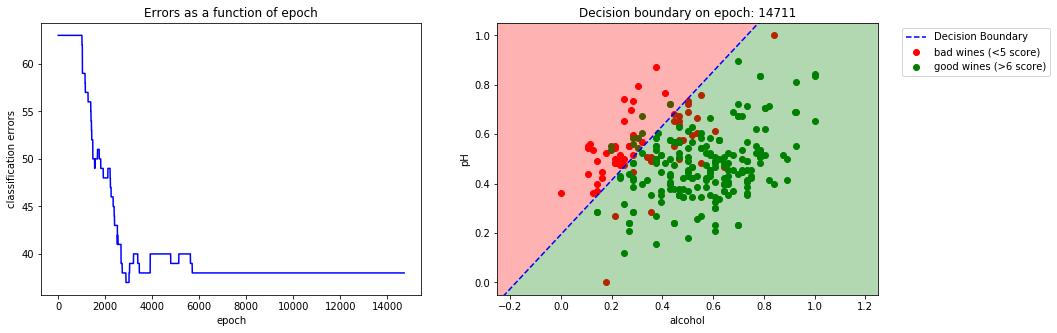

In [55]:
plot_performance(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

### d) Find a good learning rate for your ADALINE
- plot number of classification errors vs. epoch the decision boundary of your ADALINE
- What settings tend to give the smallest number of classification errors?

**0.001 learning rate is the best optimized learning rate here. Both at my customized adaline and the original adaline. The classification errors seems not to be smaller than around 20. Also as you can see in the bad wines 3 and good wines 8 samples the ADALINE seems to be thinking important of teh aesthetic drawing**

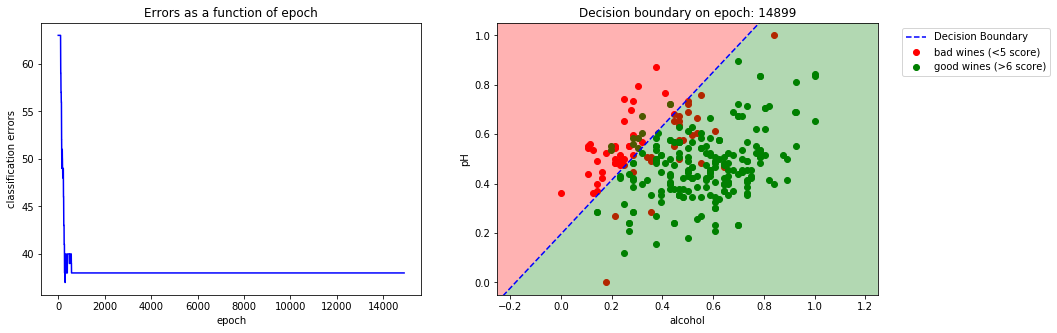

In [52]:
plot_performance(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

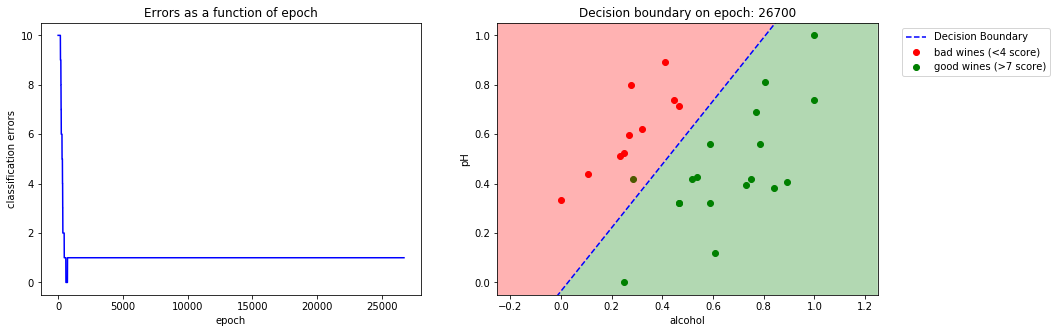

In [122]:
plot_performance(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

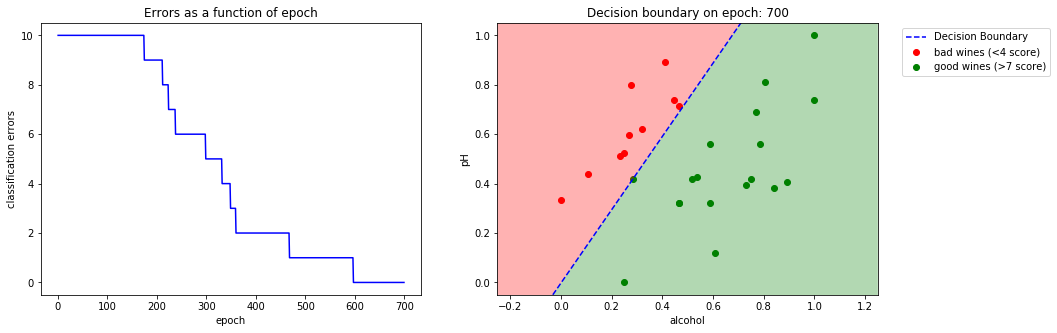

In [170]:
plot_performance(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

## V.4 Advanced wine sampling and resampling
So far, you’ve been using all your data to train your ADALINE. Training your ADALINE many times on a dataset improves its performance for that dataset. But, too much train- ing can lead to overfitting. This can lead to poor performance when the ADALINE en- counters new data it has never seen before. Using a validation set and/or cross-validation methodologies reduces (but doesn’t completely eliminate!) the possibility of overfitting!

### a) validation set 
Write a function that uses the holdout method to partition the red wine data into a training and a validation set. The function should take a parameter to adjust the proportion of training to validation data. It should return a tuple containing:

`(training_pandas_dataframe, validation_pandas_dataframe)`

In [233]:
def validation_set(wine_data, ratio=0.8, good_threshold=7, bad_threshold=4):
    # Adding one hot encoding result to the pandas data table
    y = wine_data[["quality"]].values
    y = one_hot_encoding(y, good_threshold, bad_threshold)
    wine_data['score'] = pd.Series(y, index=wine_data.index)
    wine_data["pH"] = feature_scaling(wine_data.values[:,0])
    wine_data["alcohol"]= feature_scaling(wine_data.values[:,1])

    # Sort the data out 
    good_wine = wine_data.loc[wine_data["score"] == 1, ["pH", "alcohol", "score"]]
    bad_wine = wine_data.loc[wine_data["score"] == 0, ["pH", "alcohol", "score"]]
    train_good_set = good_wine.sample(frac=ratio, random_state=100)
    validation_good_set = good_wine.drop(train_good_set.index)
    train_bad_set = bad_wine.sample(frac=ratio, random_state=100)
    validation_bad_set = bad_wine.drop(train_bad_set.index)
    train = pd.concat([train_good_set, train_bad_set])
    validation = pd.concat([validation_good_set, validation_bad_set])
    return (train, validation)
    
train_set, validation_set = validation_set(red_data)

### b) K-FOLD set 
Write a function that generates a k-fold cross-validation dataset from the red wine data. The function should allow k to be arbitrarily adjusted and also have an op- tional setting to shuffle data before creating k-folds. The function should return a list of ‘k’ tuples with each tuple containing:

`(training_pandas_dataframe, cross_validation_pandas_dataframe)`

In [232]:
def k_fold_set(wine_data, k=5, shuffle=True, ratio=0.8, good_threshold=7, bad_threshold=4):
    # Adding one hot encoding result to the pandas data table
    y = wine_data[["quality"]].values
    y = one_hot_encoding(y, good_threshold, bad_threshold)
    wine_data['score'] = pd.Series(y, index=wine_data.index)

    # Sort the unneccesary data out 
    good_wine = wine_data.loc[wine_data["score"] == 1, ["pH", "alcohol", "score"]]
    bad_wine = wine_data.loc[wine_data["score"] == 0, ["pH", "alcohol", "score"]]
    wine = pd.concat([good_wine, bad_wine])
    wine["pH"] = feature_scaling(wine.values[:,0])
    wine["alcohol"]= feature_scaling(wine.values[:,1])
    if (shuffle):
        wine = wine.sample(frac=1, random_state=int(random.random() * 100))
    chunk = wine.shape[0] // k
    k_fold = []
    for i in range(k):
        validation = wine.iloc[i * chunk : (i + 1) * chunk]
        train = wine.drop(validation.index)
        k_fold.append((train, validation))
    return (k_fold)


### c) Applying K-FOLD to ADALINE
What effects does changing learning rate and number of training epochs have on the ADALINE when evaluated via k-fold cross-validation? To address this question, you should write (or modify) a function that will train and assess the ADALINE on each training and cross-validation fold produced by your k-fold function

In [283]:
def adaline_with_k_fold(wine_data,
                        k=5,
                        shuffle=True,
                        ratio=0.8,
                        good_threshold=8,
                        bad_threshold=3,
                        lr=0.001,
                        epoch=10):
    
    # Make the k-fold training and validation set
    k_set = k_fold_set(wine_data, k, shuffle, ratio, good_threshold, bad_threshold)
    
    # Adding one hot encoding result to the pandas data table
    y = wine_data[["quality"]].values
    y = one_hot_encoding(y, good_threshold, bad_threshold)
    wine_data['score'] = pd.Series(y, index=wine_data.index)

    # Sort the data out 
    good_wine = wine_data.loc[wine_data["score"] == 1, ["pH", "alcohol", "score"]]
    bad_wine = wine_data.loc[wine_data["score"] == 0, ["pH", "alcohol", "score"]]
    good_bad_wine = pd.concat([good_wine, bad_wine])
    good_bad_wine["pH"] = feature_scaling(good_bad_wine.values[:,0])
    good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,1])
    
    a = adaline(input_size=2, lr=lr, epoch=epoch)
    for i in range(len(k_set)):
        train_x = k_set[i][0][["pH", "alcohol"]].values
        train_y = k_set[i][0]["score"].values
        valid_x = k_set[i][1][["pH", "alcohol"]].values
        valid_y = k_set[i][1]["score"].values
        a.clear_data()
        print("K-FOLD TRAIN SET {0} ACCURACY : ".format(i+1), a.train(train_x, train_y))
        print("K-FOLD VALID SET {0} ACCURACY : ".format(i+1), a.inference(valid_x, valid_y))
        plot_performance(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1)

K-FOLD TRAIN SET 1 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 1 ACCURACY :  1.0


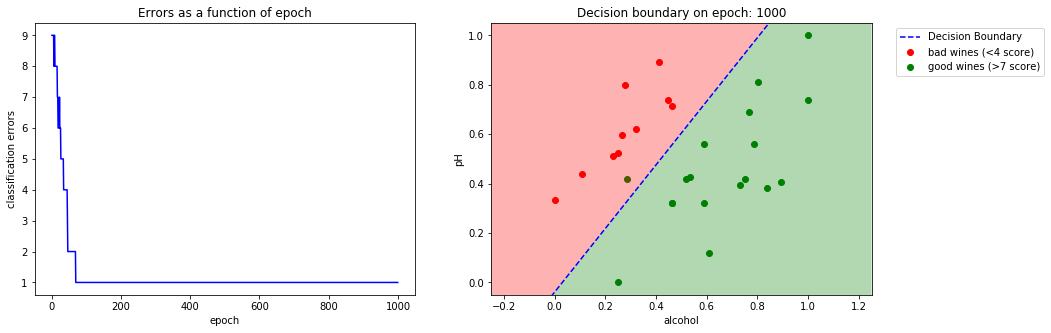

K-FOLD TRAIN SET 2 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 2 ACCURACY :  1.0


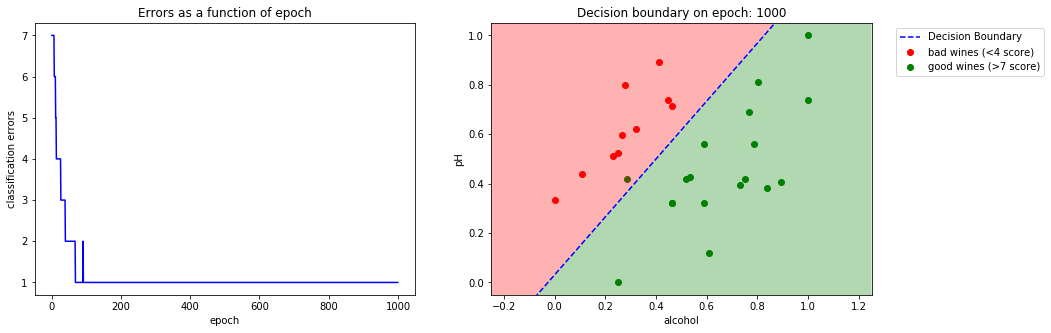

K-FOLD TRAIN SET 3 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 3 ACCURACY :  1.0


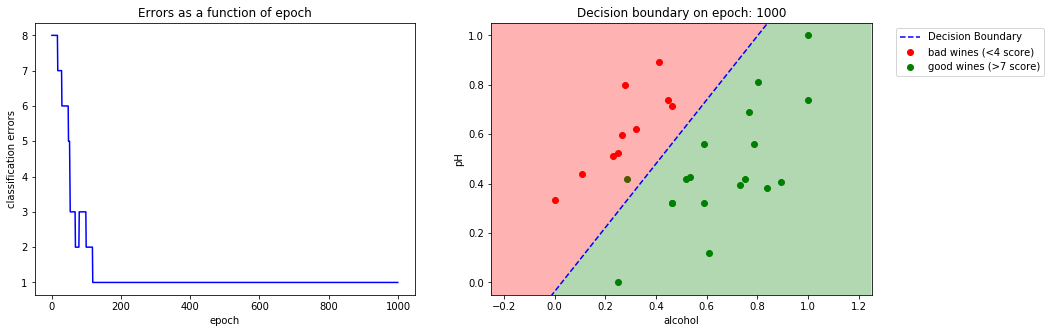

K-FOLD TRAIN SET 4 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 4 ACCURACY :  1.0


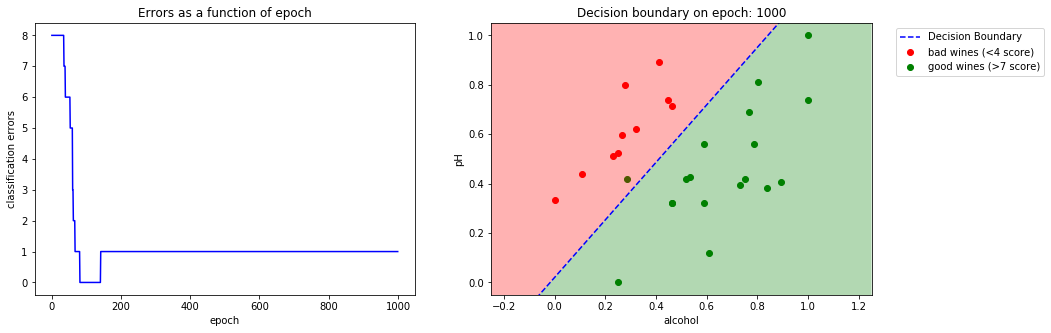

K-FOLD TRAIN SET 5 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 5 ACCURACY :  1.0


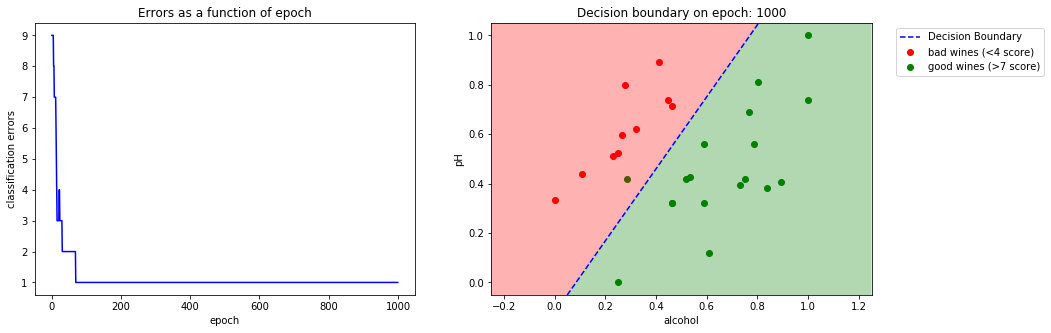

In [286]:
adaline_with_k_fold(red_data, lr=0.01, epoch=1000)

K-FOLD TRAIN SET 1 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 1 ACCURACY :  1.0


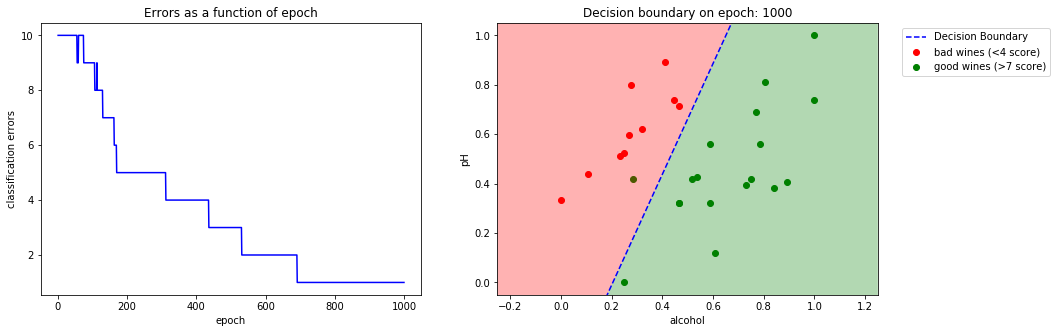

K-FOLD TRAIN SET 2 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 2 ACCURACY :  1.0


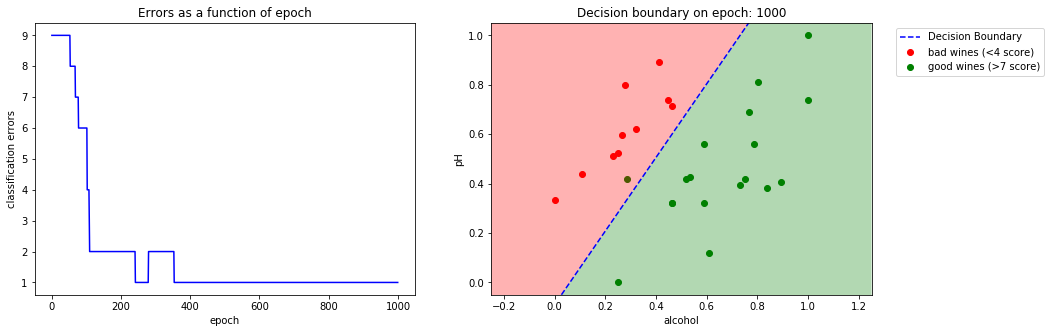

K-FOLD TRAIN SET 3 ACCURACY :  0.8695652173913043
K-FOLD VALID SET 3 ACCURACY :  1.0


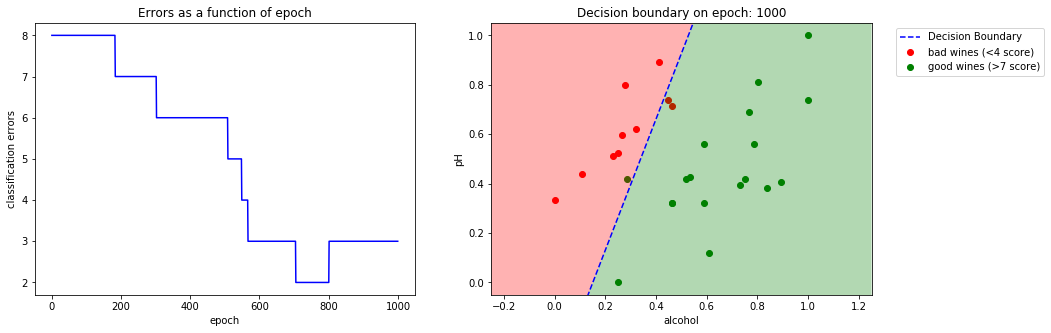

K-FOLD TRAIN SET 4 ACCURACY :  0.8695652173913043
K-FOLD VALID SET 4 ACCURACY :  0.6


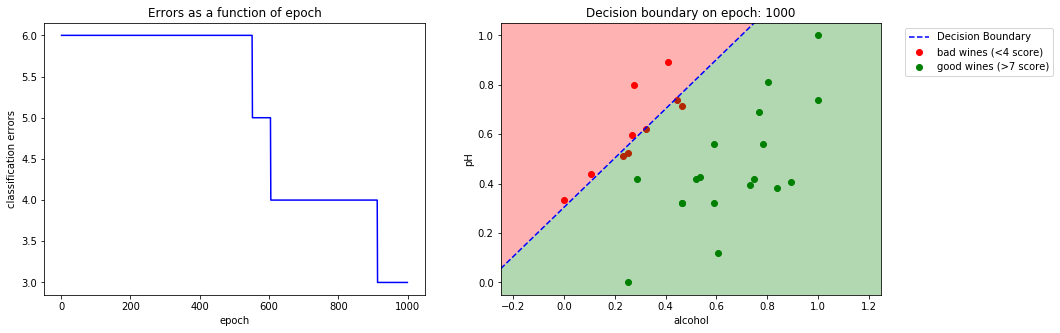

K-FOLD TRAIN SET 5 ACCURACY :  0.9565217391304348
K-FOLD VALID SET 5 ACCURACY :  0.6


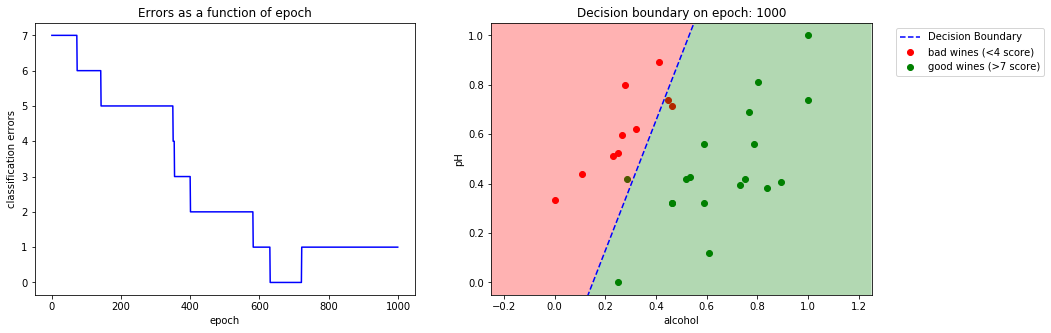

In [287]:
adaline_with_k_fold(red_data, lr=0.001, epoch=1000)

**With K-fold cross-validation set I could check the learning rate 0.01 is a great value for this data set. The accuracy is maintained at 1 so it means the training is well done and also could be applied to general datas. But in case of learning rate 0.001 K-FOLD SET 4 & 5 the accuracy is printing out lower than expected. So this means its overfitting.**
> K-FOLD cross validation allows me to check the overfitting or underfitting before I check it by actual test set. It makes the data K times bigger and also check the various set of validation, not fixed, we can check the model is good or not better compared to normal test validation set and even this is efficient in a small dataset.

## V.5 Adventures in the Nth dimension
Up until now, you’ve used only two factors in the wine data to train your perceptron and ADALINE. You wonder if it is possible to train your perceptron or ADALINE with even more chemical factors as inputs. . .

### a) Train ADALINE with more than 2 chemical factors
Try training your perceptron/ADALINE with different numbers and types of chemical factors. Under what circumstances can your perceptron/ADALINE successfully train?

In [306]:
# Initialize the input
good_threshold = 6
bad_threshold = 5

# Adding one hot encoding result to the pandas data table
y = red_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
red_data['score'] = pd.Series(y, index=red_data.index)

# Sort the data out 
good_wine = red_data.loc[red_data["score"] == 1, ["fixed acidity",
                                                  "volatile acidity",
                                                  "pH",
                                                  "sulphates",
                                                  "alcohol",
                                                  "score"]]
bad_wine = red_data.loc[red_data["score"] == 0, ["fixed acidity",
                                                  "volatile acidity",
                                                  "pH",
                                                  "sulphates",
                                                  "alcohol",
                                                  "score"]]
good_bad_wine = pd.concat([good_wine, bad_wine])
good_bad_wine["fixed acidity"] = feature_scaling(good_bad_wine.values[:,0])
good_bad_wine["volatile acidity"]= feature_scaling(good_bad_wine.values[:,1])
good_bad_wine["pH"]= feature_scaling(good_bad_wine.values[:,2])
good_bad_wine["sulphates"]= feature_scaling(good_bad_wine.values[:,3])
good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,4])
x = good_bad_wine[["fixed acidity", "volatile acidity", "pH", "sulphates", "alcohol"]].values
y = good_bad_wine["score"].values

### 5 inputs - `fixed acidity` `volatile acidity` `pH` `sulphates` `alcohol`

**good** >= 8 **bad** <= 3

In [301]:
# Testing the perceptron
a = adaline(input_size=5, lr=0.01, epoch=0, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  0.9642857142857143


**good** >= 7 **bad** <= 4

In [305]:
# Testing the perceptron
a = adaline(input_size=5, lr=0.001, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  0.9178571428571428


**good** >= 6 **bad** <= 5

In [307]:
# Testing the perceptron
a = adaline(input_size=5, lr=0.001, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  0.7304565353345841


In [310]:
# Testing the perceptron
a = adaline(input_size=5, lr=0.0005, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  0.7304565353345841


In [311]:
# Testing the perceptron
a = adaline(input_size=5, lr=0.0001, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  0.7279549718574109


### Use all the factors given
- Fixed acidity
- Volatile acidity
- Citric acid
- Residual sugar
- Chlorides
- Free sulfur dioxide 
- Total sulfur dioxide 
- Density
- pH
- Sulphates
- Alcohol

In [334]:
# Initialize the input
good_threshold = 6
bad_threshold = 5

# Adding one hot encoding result to the pandas data table
y = red_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
red_data['score'] = pd.Series(y, index=red_data.index)

# Sort the data out 
good_wine = red_data.loc[red_data["score"] == 1]
bad_wine = red_data.loc[red_data["score"] == 0]
good_bad_wine = pd.concat([good_wine, bad_wine])

good_bad_wine["fixed acidity"] = feature_scaling(good_bad_wine.values[:,0])
good_bad_wine["volatile acidity"]= feature_scaling(good_bad_wine.values[:,1])
good_bad_wine["citric acid"]= feature_scaling(good_bad_wine.values[:,2])
good_bad_wine["residual sugar"]= feature_scaling(good_bad_wine.values[:,3])
good_bad_wine["chlorides"]= feature_scaling(good_bad_wine.values[:,4])
good_bad_wine["free sulfur dioxide"]= feature_scaling(good_bad_wine.values[:,5])
good_bad_wine["total sulfur dioxide"]= feature_scaling(good_bad_wine.values[:,6])
good_bad_wine["density"]= feature_scaling(good_bad_wine.values[:,7])
good_bad_wine["pH"]= feature_scaling(good_bad_wine.values[:,8])
good_bad_wine["sulphates"]= feature_scaling(good_bad_wine.values[:,9])
good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,10])
x = good_bad_wine.iloc[:,0:11].values
y = good_bad_wine["score"].values

In [323]:
x

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
267        0.381579          0.068182     0.638889        0.461538   0.152466   
278        0.697368          0.045455     0.625000        1.000000   0.130045   
390        0.078947          0.446970     0.069444        0.038462   0.004484   
440        1.000000          0.037879     1.000000        0.192308   0.125561   
455        0.828947          0.272727     0.930556        0.769231   0.188341   
481        0.578947          0.030303     0.777778        0.307692   0.161435   
495        0.750000          0.068182     0.736111        0.269231   0.116592   
498        0.750000          0.068182     0.736111        0.269231   0.116592   
588        0.000000          0.121212     0.333333        0.153846   0.071749   
828        0.368421          0.234848     0.125000        0.211538   0.094170   
1061       0.539474          0.106061     0.694444        0.115385   0.121076   
1090       0.657895          0.000000     0.750000        0.134615   0.174888   
1120       0.381579          0.212121     0.472222        0.250000   0.143498   
1202       0.473684          0.121212     0.541667        0.115385   0.107623   
1269       0.065789          0.174242     0.041667        0.115385   0.000000   
1403       0.289474          0.053030     0.458333        0.096154   0.076233   
1449       0.289474          0.090909     0.430556        0.153846   0.053812   
1549       0.315789          0.075758     0.416667        0.115385   0.134529   
459        0.868421          0.242424     0.916667        0.192308   0.134529   
517        0.710526          0.265152     0.680556        0.173077   0.699552   
690        0.315789          0.700758     0.000000        0.586538   0.237668   
832        0.710526          0.136364     0.583333        0.057692   0.452915   
899        0.434211          0.575758     0.027778        0.423077   0.179372   
1299       0.342105          1.000000     0.000000        0.173077   0.417040   
1374       0.236842          0.420455     0.000000        0.000000   1.000000   
1469       0.302632          0.545455     0.069444        0.173077   0.076233   
1478       0.276316          0.465909     0.069444        0.865385   0.170404   
1505       0.223684          0.378788     0.027778        0.115385   0.152466   

      free sulfur dioxide  total sulfur dioxide  density        pH  sulphates  \
267              0.307692              0.354430    0.650  0.559524   0.657143   
278              0.051282              0.050633    0.680  0.416667   0.600000   
390              0.230769              1.000000    0.160  0.809524   0.600000   
440              0.076923              0.253165    0.790  0.000000   0.600000   
455              0.076923              0.126582    0.800  0.404762   0.414286   
481              0.076923              0.101266    0.560  0.321429   0.742857   
495              0.051282              0.088608    0.640  0.321429   0.357143   
498              0.051282              0.088608    0.640  0.321429   0.357143   
588              0.410256              0.518987    0.090  1.000000   0.485714   
828              0.794872              0.455696    0.337  0.690476   0.485714   
1061             0.102564              0.088608    0.382  0.392857   0.414286   
1090             1.000000              0.822785    0.371  0.119048   0.328571   
1120             0.128205              0.101266    0.155  0.380952   0.457143   
1202             0.076923              0.037975    0.436  0.559524   0.414286   
1269             0.641026              0.987342    0.000  0.738095   0.600000   
1403             0.000000              0.050633    0.520  0.416667   1.000000   
1449             0.307692              0.253165    0.392  0.416667   0.514286   
1549             0.358974              0.189873    0.339  0.428571   0.428571   
459              0.179487              0.481013    1.000  0.440476   0.242857   
517              0.051282           

**good** >= 8 **bad** <= 3

In [329]:
# Testing the perceptron
a = adaline(input_size=11, lr=0.01, epoch=0, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  1.0


**good** >= 7 **bad** <= 4

In [333]:
# Testing the perceptron
a = adaline(input_size=11, lr=0.001, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  0.9107142857142857


**good** >= 6 **bad** <= 5

In [336]:
# Testing the perceptron
a = adaline(input_size=11, lr=0.0001, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)
print("ACCURACY : ", train_accuracy)

ACCURACY :  0.7398373983739838


Feature scaling and the learning rate has a big influence on the performance. Increasing the factor doesn't affect the quality significant. Its very subtle.

### b) How does decision boundary looks like when there is more factor than 2
**You know what the decision boundary for 2 wine chemical factors looks like, but what does the decision boundary for 3 factors look like? What about if you use 7 factors? How about if you use all 11 wine chemical factors?**


>Decision boundary at factor 2 is a line, and 3 is plane. After that we enter to the 4th dimension and more. We will be lost in the nth dimension world in the middle of nowhere.

## V.6 Marvin’s rebuttal
Although you’ve managed to do a pretty decent job at predicting red wine quality given chemical characteristics, Marvin is not impressed. He gives you one more dataset for Pan-Galactic Gargle Blaster and challenges you to solve it with your single perceptron or ADALINE.

### a) THe last challenge
While not a wine... find a way to successfully classify the Pan-Galactic Gargle Blaster dataset. Show that your perceptron or ADALINE successfully classifies the Pan- Galactic Gargle Blaster data set by plotting the decision boundary and also show ‘good’ and ‘bad’ Gargle Blaster data points.

In [370]:
galatic_path = "./Pan Galactic Gargle Blaster.csv"

data = pd.read_csv(galatic_path, sep=';')

In [339]:
data

wonderflonium  fallian marsh gas  quality
0         4.151636           5.350607        2
1         3.403125           4.787343        2
2         5.036224           4.609847        2
3         4.483534           4.332340        9
4         4.215979           5.220295        2
..             ...                ...      ...
995       4.427725           4.337821        6
996       3.804685           3.697738        3
997       4.572932           3.253231        2
998       4.099439           3.240547        1
999       4.106536           4.354760        6

[1000 rows x 3 columns]

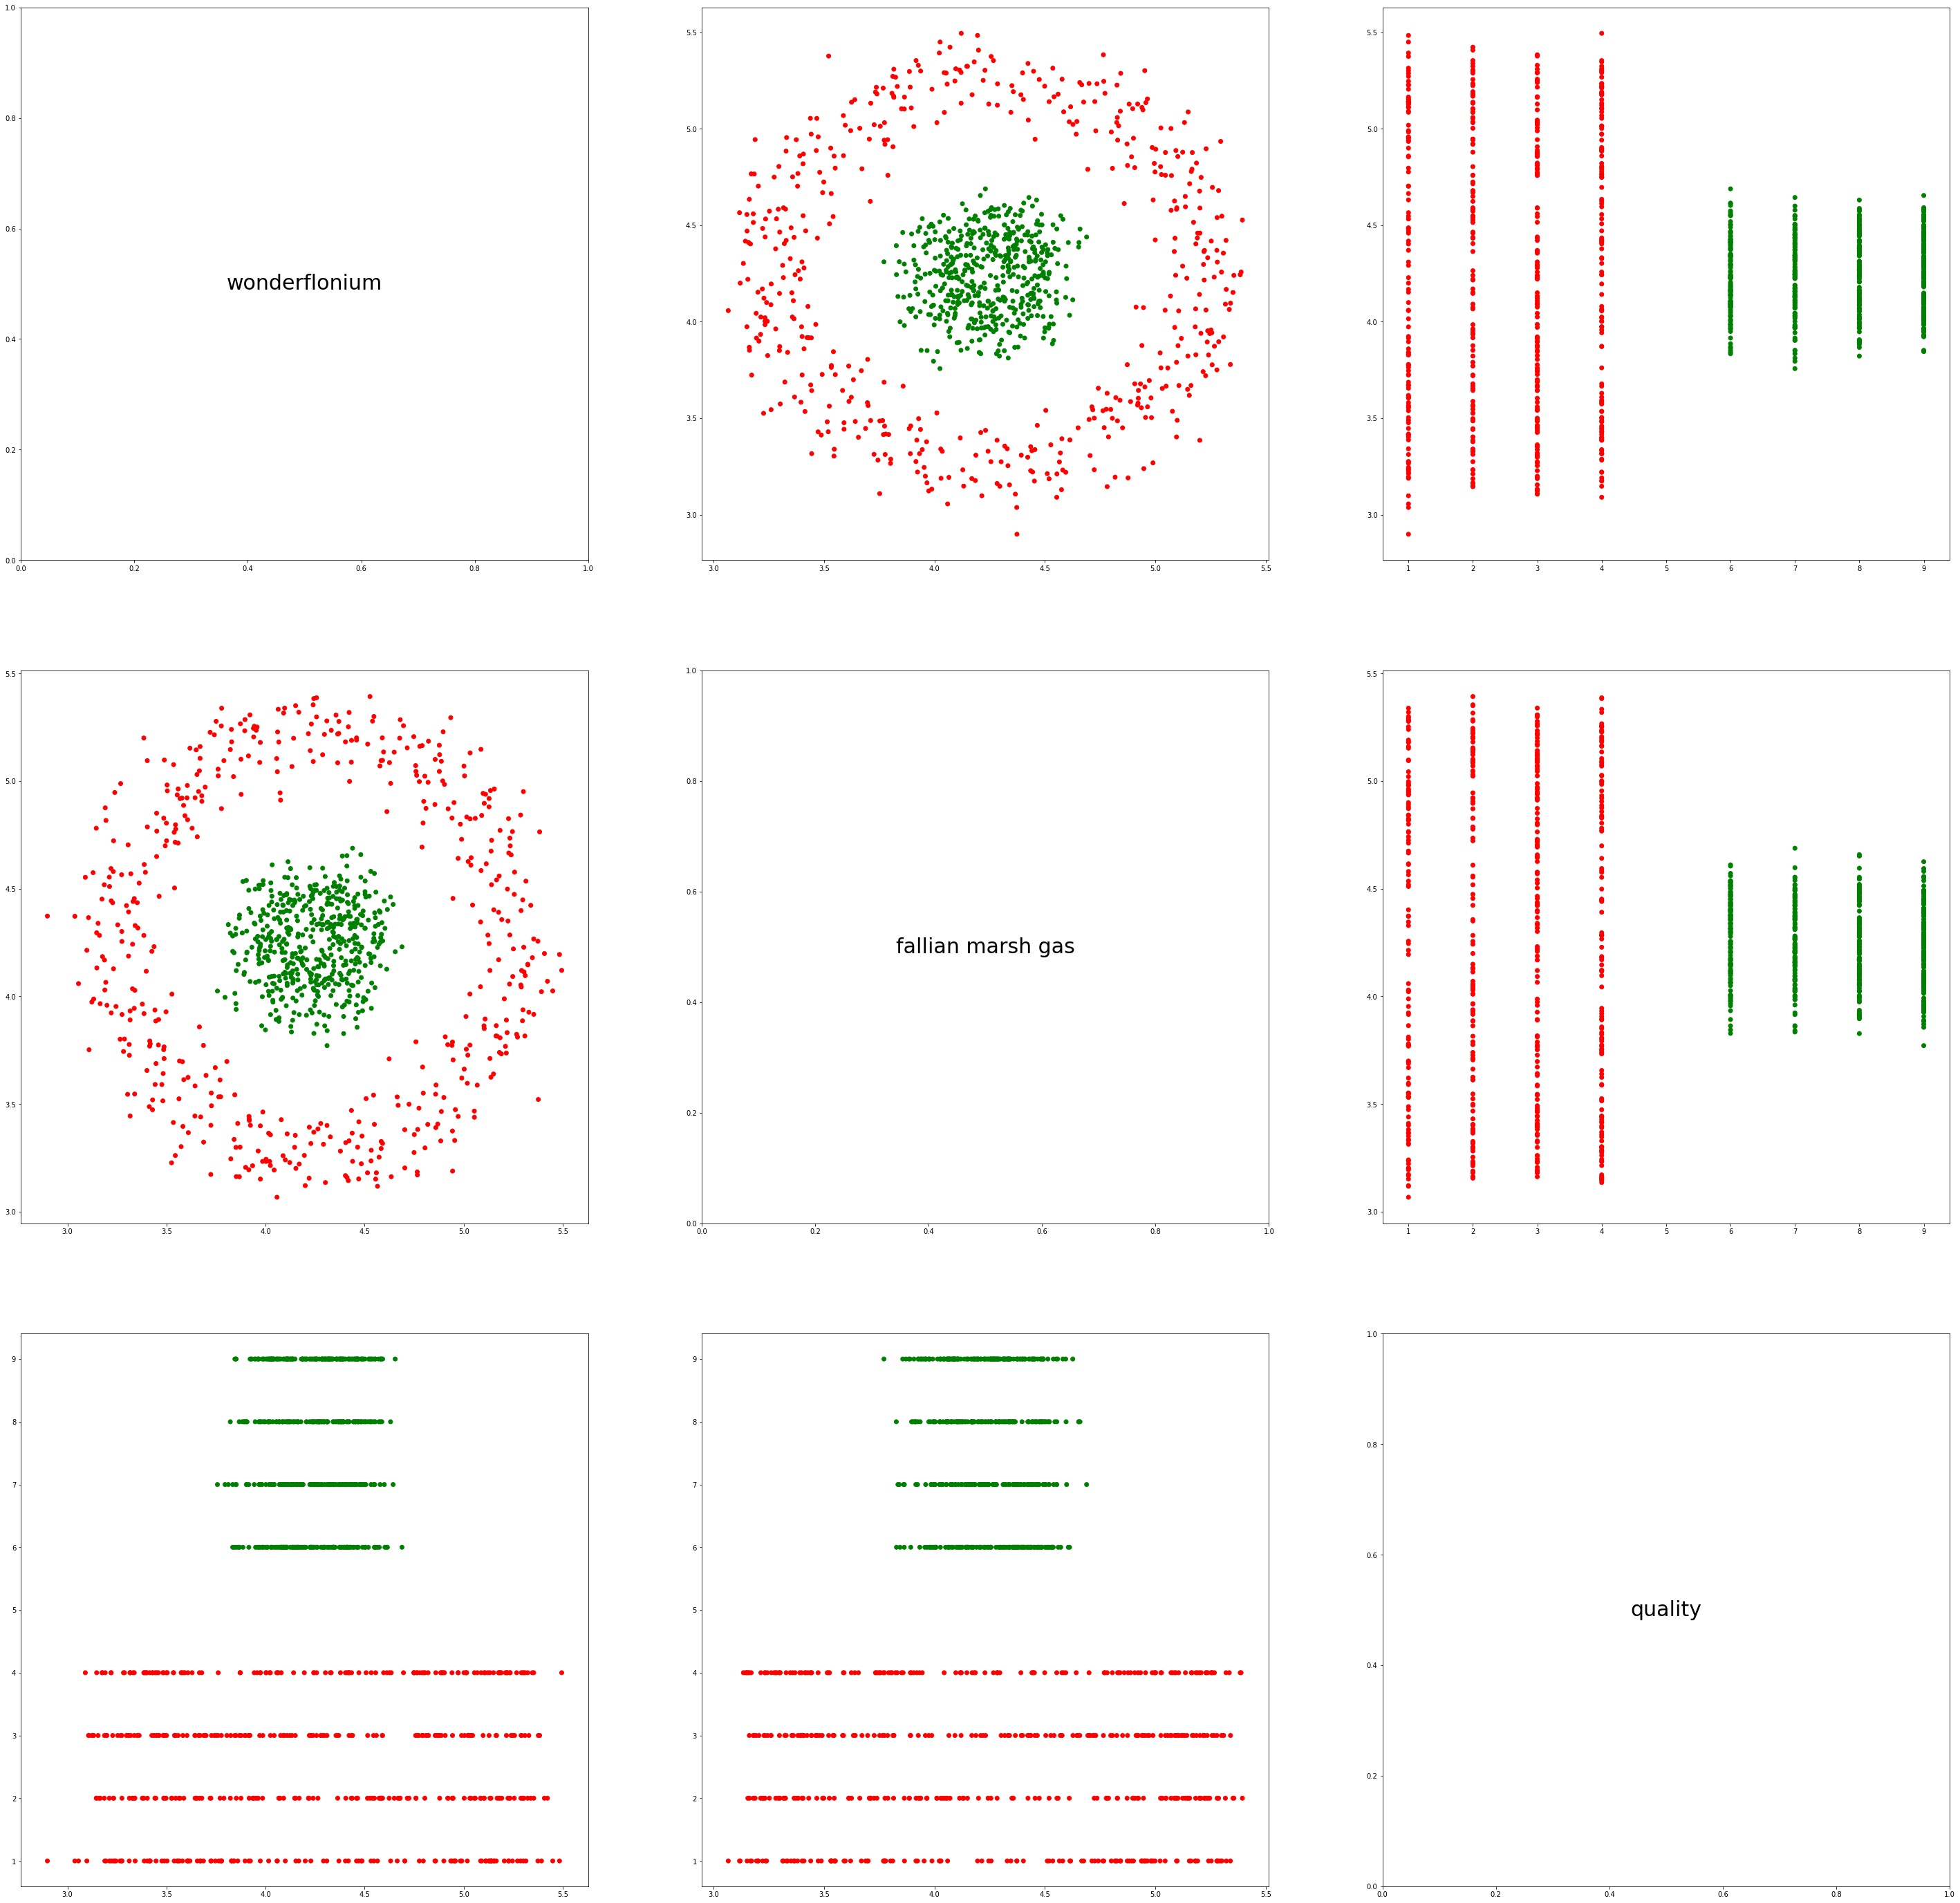

In [342]:
plot_scatter_matrix(data, 6, 5, True)

In [371]:
# Change the data to the relative world of origin
def mean_scaling(data_list):
    total = 0
    for i in range(len(data_list)):
        total += data_list[i]
    mean = total / (i + 1)
    for i in range(len(data_list)):
        data_list[i] = data_list[i] - mean
    data_max, _ = max_min(data_list)
    if (data_max == 0):
        return (data_list)
    scaled_list = []
    for i in range(len(data_list)):
        scaled_list.append(data_list[i] / data_max)
    return (scaled_list)

In [372]:
# Change the data to the relative world of origin
def square_scaling(data_list):
    scaled_list = []
    for i in range(len(data_list)):
        scaled_list.append(data_list[i] ** 2)
    return (scaled_list)

In [373]:
# Initialize the input
good_threshold = 6
bad_threshold = 5

# Adding one hot encoding result to the pandas data table
y = data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
data['score'] = pd.Series(y, index=data.index)

# Sort the data out 
good = data.loc[data["score"] == 1, ["wonderflonium", "fallian marsh gas", "score"]]
bad = data.loc[data["score"] == 0, ["wonderflonium", "fallian marsh gas", "score"]]
good_bad = pd.concat([good, bad])

In [374]:
good_bad

wonderflonium  fallian marsh gas  score
3         4.483534           4.332340      1
5         4.358374           4.484558      1
8         4.572444           4.242681      1
16        3.949503           4.064861      1
23        4.315683           4.083766      1
..             ...                ...    ...
992       5.338345           4.423047      0
994       4.679560           5.285328      0
996       3.804685           3.697738      0
997       4.572932           3.253231      0
998       4.099439           3.240547      0

[1000 rows x 3 columns]

In [376]:
good_bad["wonderflonium"] = mean_scaling(good_bad.values[:,0])
good_bad["fallian marsh gas"]= mean_scaling(good_bad.values[:,1])

In [378]:
good_bad["wonderflonium"] = square_scaling(good_bad.values[:,0])
good_bad["fallian marsh gas"]= square_scaling(good_bad.values[:,1])

In [379]:
good_bad

wonderflonium  fallian marsh gas  score
3         0.036967       5.954453e-03      1
5         0.008513       4.392970e-02      1
8         0.069331       7.024006e-07      1
16        0.054952       2.419281e-02      1
23        0.003382       1.934693e-02      1
..             ...                ...    ...
992       0.766073       2.436077e-02      0
994       0.121726       8.213059e-01      0
996       0.122588       2.255631e-01      0
997       0.069536       7.424470e-01      0
998       0.013138       7.615861e-01      0

[1000 rows x 3 columns]

In [380]:
x = good_bad[["wonderflonium", "fallian marsh gas"]].values
y = good_bad["score"].values

In [385]:
# Testing the perceptron
p = perceptron(2, lr=0.1, epoch=0, verbose=True)
p.train(x, y)

Epoch 1, accuracy : 0.991 error 9
Epoch 2, accuracy : 0.997 error 3
Epoch 3, accuracy : 0.998 error 2
Epoch 4, accuracy : 0.998 error 2
Epoch 5, accuracy : 0.998 error 2
Epoch 6, accuracy : 0.998 error 2
Epoch 7, accuracy : 0.998 error 2
Epoch 8, accuracy : 0.998 error 2
Epoch 9, accuracy : 0.998 error 2
Epoch 10, accuracy : 0.998 error 2
Epoch 11, accuracy : 0.998 error 2
Epoch 12, accuracy : 0.999 error 1
Epoch 13, accuracy : 1.0 error 0


In [386]:
p.performance

[(1, 9, [-0.07457274471034354, 0.08908887524050617], -0.12921619434097775),
 (2, 3, [-0.07055637823919679, 0.0013303125145986555], -0.029216194340977747),
 (3, 2, [-0.06739132818916382, -0.09082122050003823], -0.029216194340977747),
 (4, 2, [-0.10871459648662393, -0.11260014215872727], -0.029216194340977747),
 (5, 2, [-0.14519614409115247, -0.12215497119478437], -0.029216194340977747),
 (6, 2, [-0.181677691695681, -0.13170980023084147], -0.029216194340977747),
 (7, 2, [-0.17806109408649123, -0.18374270352581995], -0.029216194340977747),
 (8, 2, [-0.20587986845861955, -0.18653812410632856], -0.029216194340977747),
 (9, 2, [-0.23369864283074787, -0.18933354468683716], -0.029216194340977747),
 (10, 2, [-0.2392500948726661, -0.2103068196326739], -0.029216194340977747),
 (11, 2, [-0.24480154691458433, -0.23128009457851062], -0.029216194340977747),
 (12, 1, [-0.24110483733701774, -0.23068464926850685], 0.07078380565902226),
 (13, 0, [-0.24110483733701774, -0.23068464926850685], 0.07078380565

In [396]:
def Marvin_you_lost(performance, data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce a two plot figure:
    1) Classfication Errors vs. Epochs
    2) Decision boundary for two factors
    """
    # data preprocessing
    # Adding one hot encoding result to the pandas data table
    x_max, x_min = max_min(data.values[:,1])
    y_max, y_min = max_min(data.values[:,0])
    
    good = data.loc[data["score"] == 1, ["wonderflonium", "fallian marsh gas", "score"]]
    bad = data.loc[data["score"] == 0, ["wonderflonium", "fallian marsh gas", "score"]]
    
    # The values of the figure
    x_max += 0.05
    x_min -= 0.05
    y_max += 0.05
    y_min -= 0.05
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    # ax1
    ax1.set_title("Errors as a function of epoch")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("classification errors")
    
    # draw a line
    draw_epoch = pd.DataFrame(performance).iloc[0:epoch,0].values
    draw_error = pd.DataFrame(performance).iloc[0:epoch,1].values
    ax1.plot(draw_epoch, draw_error, 'b')
    
    # ax2
    ax2.set_title("Decision boundary on epoch: {0}".format(epoch if epoch != -1 else len(performance)))
    ax2.set_xlabel("fallian marsh gas")
    ax2.set_ylabel("wonderflonium")
    
    # draw a line
    # w1 -> wonderflonium (y)
    # w2 -> fallian marsh gas (x)
    # y * w1 + x * w2 + b = 0
    # y = -(w2/w1)x - b/w1
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    b = performance[epoch][3]
    plot_x = linspace(x_min, x_max, 100)
    plot_y = [(-1 * (w2 / w1) * x) - (b / w1) for x in plot_x]
    ax2.plot(plot_x, plot_y, '--b', label="Decision Boundary")
    ax2.scatter(bad.iloc[:,1].values, bad.iloc[:,0].values, color='r', label="bad marvin (<{0} score)".format(bad_thresh +1))
    ax2.scatter(good.iloc[:,1].values, good.iloc[:,0].values, color='g', label="good marvin (>{0} score)".format(good_thresh -1))
    
    # Check is the decision line is inside the figure
    # And if the decision line is out of the figure modify the figure size
    if (check_decision_line(plot_x, plot_y, x_max, x_min, y_max, y_min) == 0):
        decision_y_max, decision_y_min = max_min(plot_y)
        if (decision_y_min >= y_max):
            y_max = decision_y_max
        elif (decision_y_max <= y_min):
            y_min = decision_y_min
            
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    
    # legend
    ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Fill the color
    diff_y = y_max - y_min + 10
    plot_y_up_line = [y + diff_y for y in plot_y]
    plot_y_down_line = [y - diff_y for y in plot_y]
    ax2.fill_between(plot_x, plot_y, plot_y_up_line, where=plot_y_up_line >= plot_y, facecolor='r', alpha=0.3)
    ax2.fill_between(plot_x, plot_y, plot_y_down_line, where=plot_y_down_line < plot_y, facecolor='g', alpha=0.3)
    
    # Save the results
    if (save_plot == True):
        plt.savefig("train_result_epoch{0}.png".format(epoch))
    else:
        plt.show()

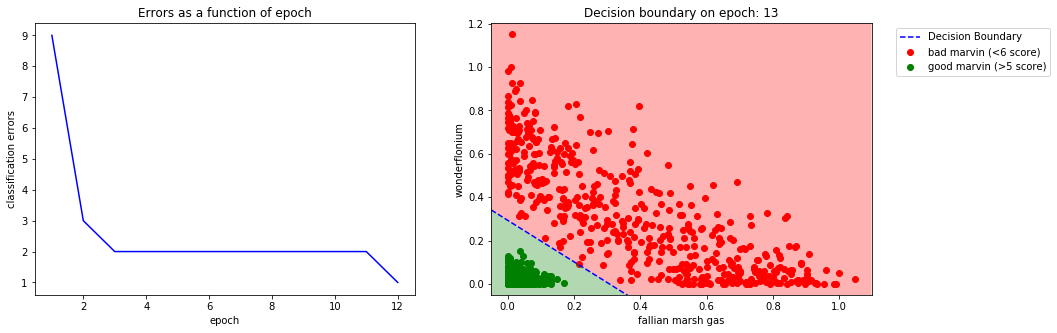

In [397]:
Marvin_you_lost(p.performance, good_bad, good_threshold, bad_threshold, epoch=-1, save_plot=False)

### We cannot handle the circle with line then why not change the dimension?
**`x^2 + y^2 = d` => `x^2 w1 + y^2 w2 = d` => `X w1 + Y w2 = d`**
> MARVIN LOST AND THE DUCK WIN!

## VI.1 Gotta go fast!
Write (or maybe rewrite!) your perceptron and ADALINE algorithm functions (Initialization, Training, Learning, and Classification/Prediction functions) as Cython functions!

## ON PROGRESS

In [499]:
%load_ext Cython

In [631]:
%%cython
from libc.stdlib cimport malloc, free, rand, srand, RAND_MAX
from cpython cimport array
import array

cdef struct s_perceptron:
    float *weights;
    float bias;
    int n_weights;
ctypedef s_perceptron t_perceptron

cdef struct s_performance:
    int epoch;
    int error_num;
    float weight[2];
    float bias;
    s_performance *next_;
ctypedef s_performance t_performance

cdef int heaviside(float activity_sum):
    if (activity_sum >= 0):
        return (1);
    else:
        return (0);
    
cdef t_perceptron *init_perceptron():
    cdef t_perceptron *p
    
    p = <t_perceptron *>malloc(sizeof(t_perceptron));
    p[0].weights = <float *>malloc(sizeof(float) * 2);
    p[0].weights[0] = rand() / RAND_MAX;
    p[0].weights[1] = rand() / RAND_MAX;
    p[0].bias = rand() / RAND_MAX;
    p[0].n_weights = 2;
    return (p);

cdef t_performance *train(t_perceptron *p, float *x, float *y):
    cdef int epoch
    
    epoch = 1;
    

cdef t_perceptron *p

p = init_perceptron();

def cython_train(float lr):
    print(p[0].n_weights)
    print(lr)

In [632]:
cython_train(0.01)

2
0.009999999776482582


## VI.2 Do perceptrons dream of electric sheep?
Peer into the decision making process of your perceptrons and ADALINEs!
Create animated plots of errors as a function of epoch and the changing decision bound- ary of your perceptron and/or ADALINE as a function of epoch. Each time step in your animation should be equivalent to advancing the training epoch by 1!

In [171]:
from matplotlib.animation import FuncAnimation

def animation(performance, wine_data, good_thresh, bad_thresh):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce a two plot figure:
    1) Classfication Errors vs. Epochs
    2) Decision boundary for two factors
    """
    # data preprocessing
    # Adding one hot encoding result to the pandas data table
    x_max, x_min = max_min(wine_data.values[:,1])
    y_max, y_min = max_min(wine_data.values[:,0])
    
    good_wine = wine_data.loc[wine_data["score"] == 1, ["pH", "alcohol", "score"]]
    bad_wine = wine_data.loc[wine_data["score"] == 0, ["pH", "alcohol", "score"]]
    
    # The values of the figure
    x_max += 0.25
    x_min -= 0.25
    y_max += 0.05
    y_min -= 0.05
    
    temp_x_max = x_max
    temp_x_min = x_min
    temp_y_max = y_max
    temp_y_min = y_min
    
    i = 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    ax1.set_xlim(0, len(performance)+10)
    ax1.set_ylim(0, 10)

    draw_epoch = pd.DataFrame(performance).iloc[0:i,0].values
    draw_error = pd.DataFrame(performance).iloc[0:i,1].values
    error_line = ax1.plot(draw_epoch, draw_error, 'b')[0]
    
    w1 = performance[i][2][0]
    w2 = performance[i][2][1]
    b = performance[i][3]
    plot_x = linspace(x_min, x_max, 100)
    plot_y = [(-1 * (w2 / w1) * x) - (b / w1) for x in plot_x]
    line_decision = ax2.plot(plot_x, plot_y, '--b', label="Decision Boundary")[0]
    scatter_bad = ax2.scatter(bad_wine.iloc[:,1].values, bad_wine.iloc[:,0].values, color='r', label="bad wines (<{0} score)".format(bad_thresh +1))
    scatter_good = ax2.scatter(good_wine.iloc[:,1].values, good_wine.iloc[:,0].values, color='g', label="good wines (>{0} score)".format(good_thresh -1))
    
    def animate(i):
        ax1.collections.clear()
        ax2.collections.clear()
        # ax1
        ax1.set_title("Errors as a function of epoch")
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("classification errors")

        # ax2
        ax2.set_title("Decision boundary on epoch: {0}".format(i))
        ax2.set_xlabel("alcohol")
        ax2.set_ylabel("pH")
        
        # Initialize the value of min max x y
        x_max = temp_x_max
        x_min = temp_x_min
        y_max = temp_y_max
        y_min = temp_y_min
        
        # draw a line
        draw_epoch = pd.DataFrame(performance).iloc[0:i,0].values
        draw_error = pd.DataFrame(performance).iloc[0:i,1].values
        error_line.set_xdata(draw_epoch)
        error_line.set_ydata(draw_error)

        w1 = performance[i][2][0]
        w2 = performance[i][2][1]
        b = performance[i][3]
        plot_x = linspace(x_min, x_max, 100)
        plot_y = [(-1 * (w2 / w1) * x) - (b / w1) for x in plot_x]
        line_decision.set_xdata(plot_x)
        line_decision.set_ydata(plot_y)
        scatter_bad = ax2.scatter(bad_wine.iloc[:,1].values, bad_wine.iloc[:,0].values, color='r', label="bad wines (<{0} score)".format(bad_thresh +1))
        scatter_good = ax2.scatter(good_wine.iloc[:,1].values, good_wine.iloc[:,0].values, color='g', label="good wines (>{0} score)".format(good_thresh -1))

        # Check is the decision line is inside the figure
        # And if the decision line is out of the figure modify the figure size
        if (check_decision_line(plot_x, plot_y, x_max, x_min, y_max, y_min) == 0):
            decision_y_max, decision_y_min = max_min(plot_y)
            if (decision_y_min >= y_max):
                y_max =  decision_y_max
            elif (decision_y_max <= y_min):
                y_min = decision_y_min
        ax2.set_xlim(x_min, x_max)
        ax2.set_ylim(y_min, y_max)

        # Fill the color
        diff_y = y_max - y_min + 10
        plot_y_up_line = [y + diff_y for y in plot_y]
        plot_y_down_line = [y - diff_y for y in plot_y]
        ax2.fill_between(plot_x, plot_y, plot_y_up_line, where=plot_y_up_line >= plot_y, facecolor='r', alpha=0.3)
        ax2.fill_between(plot_x, plot_y, plot_y_down_line, where=plot_y_down_line < plot_y, facecolor='g', alpha=0.3)
        
        # legend
        ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        return (ax1, ax2)
    
    anim = FuncAnimation(fig, animate, interval=120, frames=len(performance))
    anim.save("animation.mp4")
    plt.draw()
    plt.show()


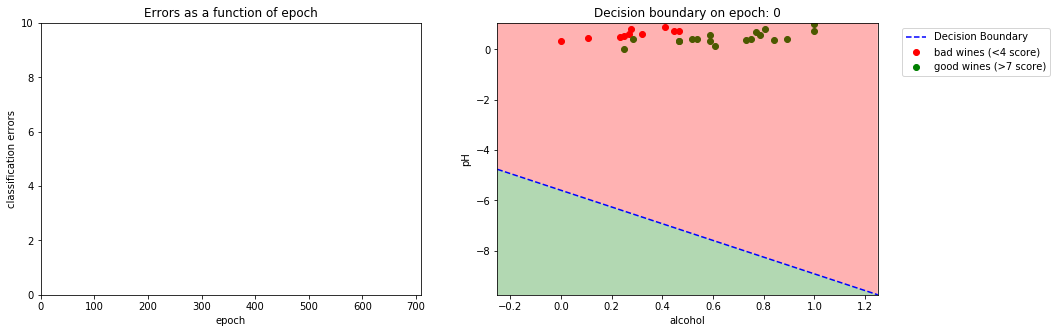

In [173]:
animation(a.performance, good_bad_wine, good_threshold, bad_threshold)

## VI.3 Dimensional traveler
Create a function that can plot the decision boundary when you train your perceptron or ADALINE on 3 different factors! Your plot will of course need to plot the actual wine data points in 3-factor space as well!

> PDF doesn't allow me to use numpy so I made `numpy meshgrid function`. But Z must be numpy array so I use numpy by putting the list in the `pandas dataframe` and using `value`

In [408]:
from mpl_toolkits.mplot3d import Axes3D

In [547]:
def mesh(x, y):
    mesh_x = [[0 for _ in range(len(x))] for _ in range(len(y))]
    mesh_y = [[0 for _ in range(len(y))] for _ in range(len(x))]
    for i in range(len(y)):
        for j in range(len(x)):
            mesh_x[i][j] = x[j]
    for i in range(len(x)):
        for j in range(len(y)):
            mesh_y[i][j] = y[j]
    mesh_y = transpose_matrix_2d(mesh_y)
    return (mesh_x, mesh_y)

In [617]:
def plot_performance_3D(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    This function will produce a two plot figure:
    1) Classfication Errors vs. Epochs
    2) Decision boundary for two factors
    """
    # data preprocessing
    # Adding one hot encoding result to the pandas data table
    x_max, x_min = max_min(wine_data.values[:,2])
    y_max, y_min = max_min(wine_data.values[:,1])
    z_max, z_min = max_min(wine_data.values[:,0])
    
    good_wine = wine_data.loc[wine_data["score"] == 1, ["volatile acidity", "pH", "alcohol", "score"]]
    bad_wine = wine_data.loc[wine_data["score"] == 0, ["volatile acidity", "pH", "alcohol", "score"]]
    
    # The values of the figure
    x_max += 0.25
    x_min -= 0.25
    y_max += 0.05
    y_min -= 0.05
    z_max += 0.05
    z_min -= 0.05
    
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')
    
    # ax2
    ax.set_title("Decision boundary on epoch: {0}".format(epoch if epoch != -1 else len(performance)))
    ax.set_xlabel("alcohol")
    ax.set_ylabel("pH")
    ax.set_zlabel("volatile acidity")
    
    # draw a line
    # w1 -> volatile acidity (z)
    # w2 -> pH (y)
    # w3 -> alcohol (x)
    # z * w1 + y * w2 + x * w3 + b = 0
    # z = -(w2/w1)y -(w3/w1)x - b/w1
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    w3 = performance[epoch][2][2]
    b = performance[epoch][3]
    plot_x = linspace(x_min + 0.25, x_max - 0.25, 1)
    plot_y = linspace(y_min + 0.25, y_max - 0.25, 1)
    
    xx, yy = mesh(plot_x, plot_y)
    xx = pd.DataFrame(xx).values
    yy = pd.DataFrame(yy).values
    z = (-1 * (w2 / w1) * yy) + (-1 * (w3 / w1) * xx) - (b / w1)
    ax.plot_surface(xx, yy, z, color='b', alpha='0.5')
    
    ax.scatter3D(bad_wine.iloc[:,2].values,
                 bad_wine.iloc[:,1].values,
                 bad_wine.iloc[:,0].values, color='r', label="bad wines (<{0} score)".format(bad_thresh +1))
    ax.scatter3D(good_wine.iloc[:,2].values,
                 good_wine.iloc[:,1].values,
                 good_wine.iloc[:,0].values, color='g', label="good wines (>{0} score)".format(good_thresh -1))
    
    # Check is the decision line is inside the figure
    # And if the decision line is out of the figure modify the figure size
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    # legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Save the results
    if (save_plot == True):
        plt.savefig("train_result_epoch{0}.png".format(epoch))
    else:
        plt.show()

In [614]:
# Initialize the input
good_threshold = 6
bad_threshold = 5

# Adding one hot encoding result to the pandas data table
y = red_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
red_data['score'] = pd.Series(y, index=red_data.index)

# Sort the data out 
good_wine = red_data.loc[red_data["score"] == 1, ["volatile acidity",
                                                  "pH",
                                                  "alcohol",
                                                  "score"]]
bad_wine = red_data.loc[red_data["score"] == 0, ["volatile acidity",
                                                 "pH",
                                                 "alcohol",
                                                 "score"]]
good_bad_wine = pd.concat([good_wine, bad_wine])
good_bad_wine["volatile acidity"]= feature_scaling(good_bad_wine.values[:,0])
good_bad_wine["pH"]= feature_scaling(good_bad_wine.values[:,1])
good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,2])
x = good_bad_wine[["volatile acidity", "pH", "alcohol"]].values
y = good_bad_wine["score"].values

In [615]:
a = adaline(input_size=3, lr=0.001, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)

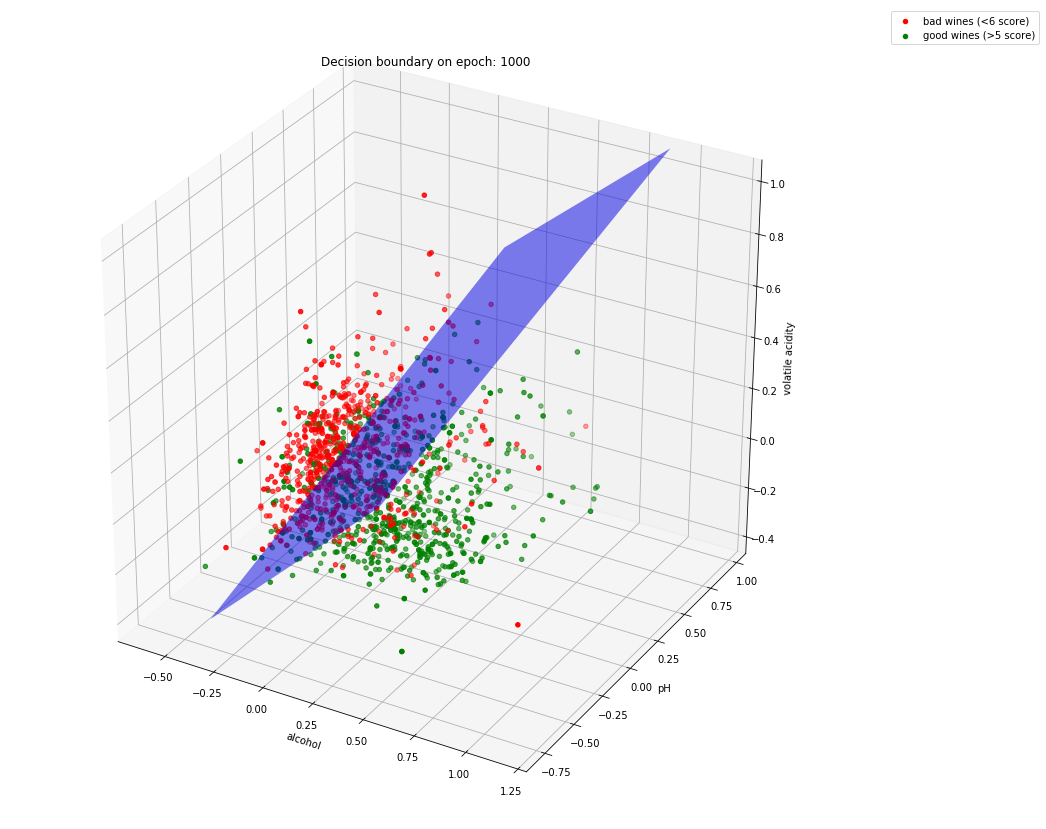

In [618]:
plot_performance_3D(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

In [619]:
# Initialize the input
good_threshold = 6
bad_threshold = 5

# Adding one hot encoding result to the pandas data table
y = white_data[["quality"]].values
y = one_hot_encoding(y, good_threshold, bad_threshold)
white_data['score'] = pd.Series(y, index=white_data.index)

# Sort the data out 
good_wine = white_data.loc[white_data["score"] == 1, ["volatile acidity",
                                                      "pH",
                                                      "alcohol",
                                                      "score"]]
bad_wine = white_data.loc[white_data["score"] == 0, ["volatile acidity",
                                                     "pH",
                                                     "alcohol",
                                                     "score"]]
good_bad_wine = pd.concat([good_wine, bad_wine])
good_bad_wine["volatile acidity"]= feature_scaling(good_bad_wine.values[:,0])
good_bad_wine["pH"]= feature_scaling(good_bad_wine.values[:,1])
good_bad_wine["alcohol"]= feature_scaling(good_bad_wine.values[:,2])
x = good_bad_wine[["volatile acidity", "pH", "alcohol"]].values
y = good_bad_wine["score"].values

In [621]:
a = adaline(input_size=3, lr=0.0001, epoch=1000, verbose=False)
train_accuracy = a.train(x, y)

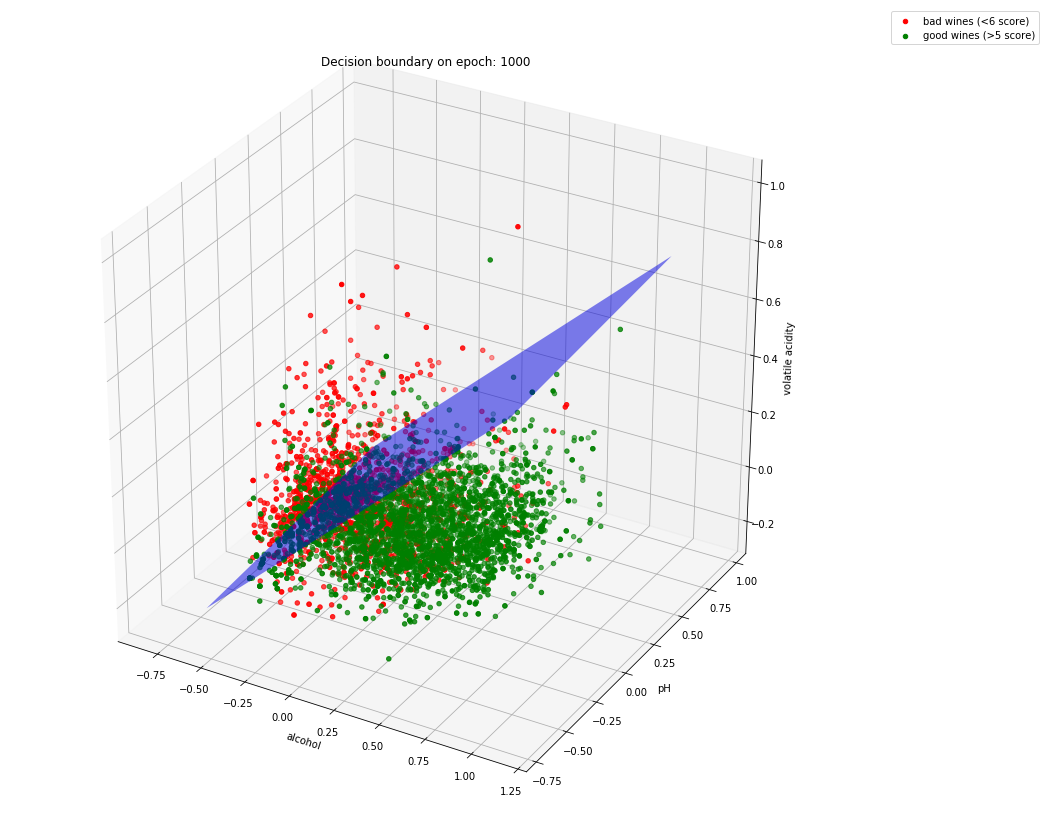

In [622]:
plot_performance_3D(a.performance, good_bad_wine, good_threshold, bad_threshold, epoch=-1, save_plot=False)

## VV.V ITS TIME TO LEAVE

In [635]:
!tar chvfz notebook.tar.gz *

Pan Galactic Gargle Blaster.csv
animation.mp4
ft_sommelier.ipynb
ft_sommelier.zip
ft_sommelier_animation_example.mp4
train_result_epoch-1.png
wine_result.png
winequality-red.csv
winequality-white.csv
